In [1]:
!pip install imutils

#Basics
import re
import os, sys
import shutil
import pandas as pd
import numpy as np
from tqdm import tqdm
import json
import itertools

#Imaging
from imutils import paths
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import imageio
import plotly.express as px

#Torch
from torchvision import transforms
from torchvision import models
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import ReduceLROnPlateau

import collections
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import plotly.graph_objects as go
from sklearn.metrics import classification_report

import albumentations as A
from albumentations.pytorch import ToTensorV2


# Dataset script for Dataloader
#from glyph_dataset import *

# TODO: Connected Component Analysis

  Preparing metadata (setup.py) ... done
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25834 sha256=7523bf2d3d4391a3d830234e598355c5c266d3fd2810b8e4b172d0ddef305417
  Stored in directory: /root/.cache/pip/wheels/85/cf/3a/e265e975a1e7c7e54eb3692d6aa4e2e7d6a3945d29da46f2d7
Successfully built imutils


In [2]:
from torch.utils.data import DataLoader, Dataset
import os
import matplotlib.image as mpimg
import numpy as np
import json

class Glyph_Dataset(Dataset):
    def __init__(self, dataset_path, label_encoder_file, augmentation=None, preprocessing=None, transform=None, oversample_factor=0):
        self.dataset_path = dataset_path
        self.filenames = os.listdir(dataset_path)
        self.augmentation = augmentation
        self.preprocessing = preprocessing
        self.transform = transform
        self.oversample_factor = oversample_factor

        with open(label_encoder_file, 'r') as f:
            self.label_encoder = json.load(f)
            
        # Balance the dataset by oversampling minority classes
        self.balanced_filenames = self.balance_dataset()

    def __len__(self):
        return len(self.balanced_filenames)
    
    def balance_dataset(self):
        # If oversample_factor is 0, do not perform any oversampling
        if self.oversample_factor == 0:
            return self.filenames

        # Count the occurrences of each class
        class_counts = {}
        for filename in self.filenames:
            last_underscore_index = filename.rfind('_')
            label_str = filename[last_underscore_index + 1:filename.rfind('.')]
            label_int = self.label_encoder[label_str]
            class_counts[label_int] = class_counts.get(label_int, 0) + 1

        max_count = max(class_counts.values())
        target_count = max_count * self.oversample_factor
        balanced_filenames = []

        # Oversample each class to match the target count
        for filename in self.filenames:
            last_underscore_index = filename.rfind('_')
            label_str = filename[last_underscore_index + 1:filename.rfind('.')]
            label_int = self.label_encoder[label_str]
            count = class_counts[label_int]

            # Only oversample classes below the target count
            if count < target_count:
                multiplier = int(target_count // count)
                additional_samples = int((target_count / count - multiplier) * self.oversample_factor)
                balanced_filenames.extend([filename] * (multiplier + additional_samples))
            else:
                balanced_filenames.append(filename)

        return balanced_filenames

    def __getitem__(self, index):
        actual_index = index % len(self.balanced_filenames)
        image_path = os.path.join(self.dataset_path, self.balanced_filenames[actual_index])
        image = mpimg.imread(image_path)

        last_underscore_index = self.balanced_filenames[actual_index].rfind('_')
        label_str = self.balanced_filenames[actual_index][last_underscore_index + 1:self.balanced_filenames[actual_index].rfind('.')]
        label_int = self.label_encoder[label_str]

        if self.preprocessing:
            preprocessed = self.preprocessing(image)
            image = preprocessed["image"]

        if self.augmentation:
            augmented = self.augmentation(image=image)['image']
            
        if self.transform:
            image = self.transform(image)

        return image, label_int

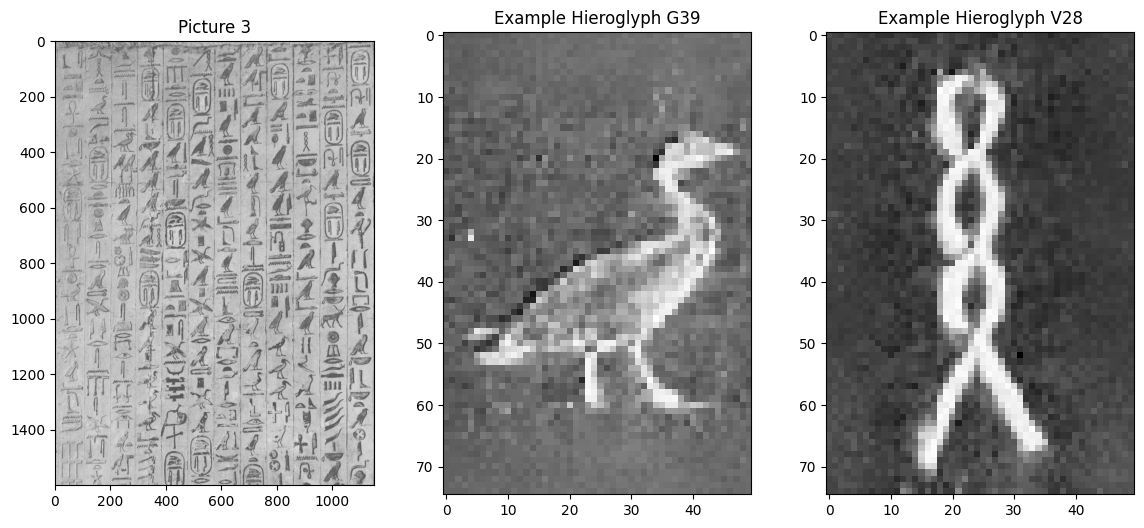

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(14,6))

# Plot full
axes[0].imshow(mpimg.imread(r"/kaggle/input/glyphdataset/Dataset/Pictures/egyptianTexts3.jpg"))
axes[0].set_title("Picture 3")

# Plot glyph
axes[1].imshow(mpimg.imread(r"/kaggle/input/glyphdataset/Dataset/Automated/Preprocessed/3/030010_G39.png"),cmap='Greys')
axes[1].set_title("Example Hieroglyph G39")

# Plot glyph
im = axes[2].imshow(mpimg.imread(r"/kaggle/input/glyphdataset/Dataset/Automated/Preprocessed/3/030370_V28.png"),cmap='Greys')
axes[2].set_title("Example Hieroglyph V28")

plt.show()

In [4]:
source_dir = '/kaggle/input/glyphdataset/Dataset/Manual/Preprocessed'
target_dir = 'GlyphDataset/Train'

# Create the target directory if it doesn't exist
os.makedirs(target_dir, exist_ok=True)

# Function to copy all files from source to target directory
def copy_files(source, target):
    for item in tqdm(os.listdir(source)):
        s = os.path.join(source, item)
        d = os.path.join(target, item)
        if os.path.isdir(s):
            os.makedirs(d, exist_ok=True)  # Create directory if not exists
            copy_files(s, d)  # Recursively copy subdirectory
        else:
            shutil.copy2(s, d)  # Copy files and preserve metadata

# Copy all files and subdirectories
copy_files(source_dir, target_dir)
print("Folder contents copied successfully!")


100%|██████████| 10/10 [00:10<00:00,  1.08s/it]

Folder contents copied successfully!


In [5]:
train_dir = 'GlyphDataset/Train'

# Step 1: Move all .png files to the train_dir
for root, dirs, files in os.walk(train_dir, topdown=False):  # topdown=False is important for later deletion
    for file in files:
        if file.endswith('.png'):
            # Construct the full file path
            file_path = os.path.join(root, file)
            # Construct the target file path
            target_path = os.path.join(train_dir, file)
            
            # Move the file
            shutil.move(file_path, target_path)

# Step 2: Remove all empty directories
for root, dirs, files in os.walk(train_dir, topdown=False):
    for dir in dirs:
        dir_path = os.path.join(root, dir)
        # Check if the directory is empty
        if not os.listdir(dir_path):
            try:
                os.rmdir(dir_path)
                print(f"Removed empty directory: {dir_path}")
            except Exception as e:
                print(f"Failed to remove {dir_path}: {e}")
                
#Step 3: Remove all UNKNOWN files
for root, dirs, files in os.walk(train_dir, topdown=False):
    for file in files:
        if file.endswith('_UNKNOWN.png'):
            file_path = os.path.join(root, file)
            try:
                os.remove(file_path)
            except Exception as e:
                print(f"Failed to remove {file_path}: {e}")


Removed empty directory: GlyphDataset/Train/22
Removed empty directory: GlyphDataset/Train/41
Removed empty directory: GlyphDataset/Train/23
Removed empty directory: GlyphDataset/Train/5
Removed empty directory: GlyphDataset/Train/20
Removed empty directory: GlyphDataset/Train/3
Removed empty directory: GlyphDataset/Train/21
Removed empty directory: GlyphDataset/Train/9
Removed empty directory: GlyphDataset/Train/39
Removed empty directory: GlyphDataset/Train/7


In [6]:
# Functions:

def create_label_encoding_file(dataset_path, file_path='label_encoding.json'):
    filenames = os.listdir(dataset_path)
    labels = [filename[filename.rfind('_')+1:filename.rfind('.')] for filename in filenames]
    unique_labels = sorted(set(labels))
    label_to_int = {label: idx for idx, label in enumerate(unique_labels)}
    
    with open(file_path, 'w') as f:
        json.dump(label_to_int, f)

def load_label_mappings(file_path):
    with open(file_path, 'r') as f:
        label_to_int = json.load(f)
    int_to_label = {v: k for k, v in label_to_int.items()}
    return label_to_int, int_to_label

def plot_label_distribution(pred_list, label_list):
    """
    Plots the actual vs predicted label distribution.

    Parameters:
    pred_list (list of numpy arrays): List of prediction arrays from the model.
    label_list (list of int): List of true labels.

    Returns:
    None
    """
    # Convert predictions to predicted class indices
    predicted_classes = [np.argmax(pred) for pred in pred_list]
    true_labels = [label for label in label_list]

    # Load mappings
    _, int_to_label = load_label_mappings('label_encoding.json')

    # Convert class indices back to label codes
    predicted_codes = [int_to_label[pred] for pred in predicted_classes]
    true_codes = [int_to_label[label] for label in true_labels]

    # Get all unique labels present in both true and predicted data
    all_labels = np.union1d(np.unique(true_codes), np.unique(predicted_codes))

    # Count occurrences of each label in both actual and predicted
    counts_true = np.zeros(len(all_labels), dtype=int)
    counts_pred = np.zeros(len(all_labels), dtype=int)

    for i, label in enumerate(all_labels):
        counts_true[i] = np.sum(np.array(true_codes) == label)
        counts_pred[i] = np.sum(np.array(predicted_codes) == label)

    # Create traces for the actual and predicted data
    trace1 = go.Bar(
        y=all_labels, 
        x=counts_true, 
        name='Actual Labels', 
        orientation='h'
    )

    trace2 = go.Bar(
        y=all_labels, 
        x=counts_pred, 
        name='Predicted Labels', 
        orientation='h'
    )

    # Create the figure
    fig = go.Figure(data=[trace1, trace2])

    # Update layout
    fig.update_layout(
        title='Actual vs Predicted Label Distribution',
        barmode='group',
        bargap=0.15,  # controls the gap between bars of different sets
        bargroupgap=0.1,  # controls the gap between bars of the same set
        autosize=False,
        width=1000,
        height=1200,
        yaxis=dict(
            title='Class Labels'
        ),
        xaxis=dict(
            title='Frequency'
        )
    )

    # Show the plot
    fig.show()
    return true_codes, predicted_codes

In [7]:
create_label_encoding_file(train_dir)

In [8]:
BATCH_SIZE = 32
NUM_WORKERS = 5
SHUFFLE = False

In [9]:
# Define transformations work in progress
# class transform(object):
#     def normalize_img(self, img, mean=['?'], std=['?']):
#         return '?'

transform = transforms.Compose([
    transforms.ToTensor()
])

augmentation = A.Compose([
    A.Rotate(limit=5, p=0.2),
    A.GaussianBlur(blur_limit=(1, 3), p=0.2),
    A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.2),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=10, p=0.2),
    ToTensorV2()
])

# Exploratory data analysis (EDA):

In [10]:
train_ds = Glyph_Dataset(dataset_path="GlyphDataset/Train",
                        label_encoder_file= 'label_encoding.json',
                        transform=transform,
                        augmentation=None,
                        preprocessing=None,
                        oversample_factor=0)

print("Length of normal training data: ",len(train_ds))

train_au = Glyph_Dataset(dataset_path="GlyphDataset/Train",
                        label_encoder_file= 'label_encoding.json',
                        transform=transform,
                        augmentation=None,
                        preprocessing=None,
                        oversample_factor=0.2)

print("Length of oversampled training data: ",len(train_au))

train_loader = DataLoader(train_ds,
                        batch_size=BATCH_SIZE,
                        num_workers=NUM_WORKERS,
                        shuffle=SHUFFLE)

Length of normal training data:  4031
Length of oversampled training data:  15837


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [11]:
images, labels = next(iter(train_loader))

In [12]:
images.shape

torch.Size([32, 1, 75, 50])

In [13]:
labels.shape

torch.Size([32])

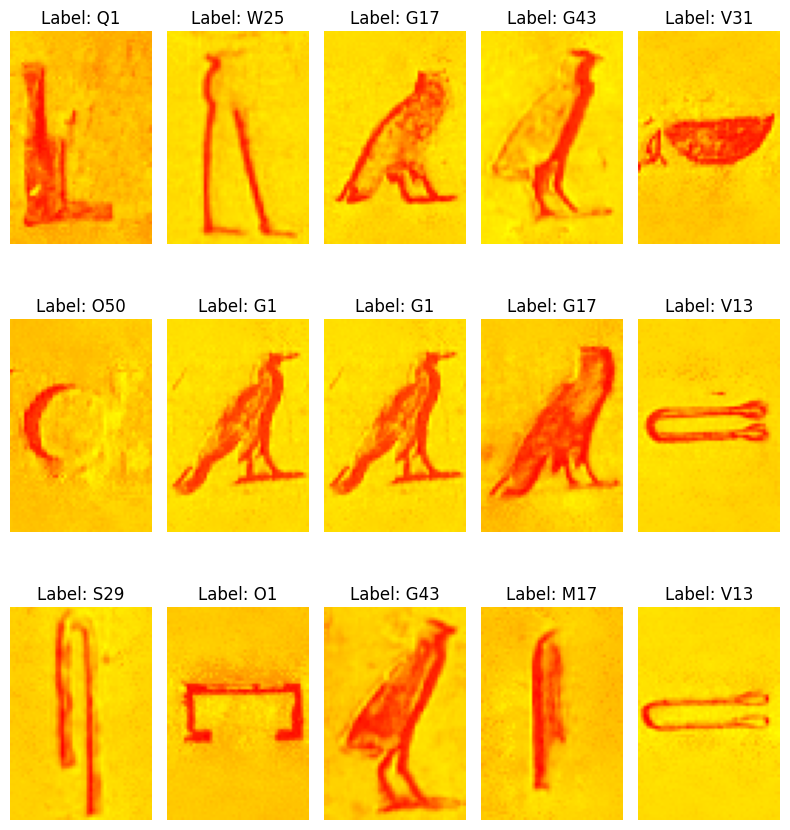

In [14]:
fig, axis = plt.subplots(3, 5, figsize=(8, 9))

for ax in axis.flat:
    _, int_to_label = load_label_mappings('label_encoding.json')
    i = np.random.randint(len(labels))
    decoded_label = int_to_label[float(labels[i])]

    ax.imshow(images[i,0,:,:], cmap='autumn')
    ax.set(title = f"Label: {decoded_label}")
    ax.set_axis_off()

plt.tight_layout()
plt.show()

In [15]:
labels = []
for filename in os.listdir("GlyphDataset/Train"):
    last_underscore_index = filename.rfind('_')
    label = filename[last_underscore_index+1:filename.rfind('.')]
    labels.append(label)

codes, counts = np.unique(labels, return_counts=True)

In [16]:
codes, counts = np.unique(labels, return_counts=True)

sorted_indices = np.argsort(counts)
sorted_codes = codes[sorted_indices]
sorted_counts = counts[sorted_indices]

exclusion_count = 130  # Excluding a bunch of the lowest out of the plot
filtered_codes = sorted_codes[exclusion_count:]
filtered_counts = sorted_counts[exclusion_count:]

fig = px.bar(
    x=filtered_counts,
    y=filtered_codes,
    orientation='h',
    labels={'x': 'Count', 'y': 'Codes'},
    title='Horizontal Bar Chart of Codes'
)

# Add a vertical line at count = 32
fig.update_layout(
    shapes=[
        dict(
            type='line',
            xref='x',
            yref='paper',
            x0=32,
            y0=0,
            x1=32,
            y1=1,
            line=dict(color='red', width=4, dash='dash'),
        )
    ],
    autosize=False,
    width=1000,
    height=1200
)

# Show the plot
fig.show()

In [17]:
train_dir = 'GlyphDataset/Train'
filepaths = [os.path.join(train_dir, filename) for filename in sorted(os.listdir(train_dir))]

In [18]:
class_count = collections.Counter(labels)

# Threshold for minimum samples for class to be included in stratification
min_samples_per_class = 8

train_files_direct = [f for f, l in zip(filepaths, labels) if class_count[l] < min_samples_per_class]
train_labels_direct = [l for f, l in zip(filepaths, labels) if class_count[l] < min_samples_per_class]
stratify_files = [f for f, l in zip(filepaths, labels) if class_count[l] >= min_samples_per_class]
stratify_labels = [l for f, l in zip(filepaths, labels) if class_count[l] >= min_samples_per_class]


In [19]:
# We split Train into two, then the smaller part again for 3 splits
train_files, test_val_files, train_labels, test_val_labels = train_test_split(
    stratify_files, stratify_labels, test_size=0.3, random_state=23, stratify=stratify_labels)

# Further split test_val into validation and test sets
val_files, test_files, val_labels, test_labels = train_test_split(
    test_val_files, test_val_labels, test_size=0.5, random_state=23, stratify=test_val_labels)


In [20]:
def copy_files(file_list, dest_folder):
    os.makedirs(dest_folder, exist_ok=True)
    for file in file_list:
        shutil.move(file, dest_folder)

parent_dir = "GlyphDataset/"

copy_files(val_files, os.path.join(parent_dir, 'Validation'))
copy_files(test_files, os.path.join(parent_dir, 'Test'))

In [21]:
print(len(os.listdir('GlyphDataset/Train')))
print(len(os.listdir('GlyphDataset/Validation')))
print(len(os.listdir('GlyphDataset/Test')))

2906
562
563


# Model: Paper on 172 Classes

Instead of the 40 most popular labels used in the paper, this model inspired by the paper will be trained on the 172 labels.

In [74]:
# PARAMS
BATCH_SIZE = 60
NUM_WORKERS = 4
PIN_MEMORY = False
SHUFFLE = False # True is supposed to generalise better
LEARNING_RATE = 1e-3
NUM_EPOCHS = 50
PATIENCE = 10
# NUM_BATCHES = 10 this one when want to break early, train just one batch etc.
LOAD_MODEL = False
DEVICE = 'cuda'

In [75]:
# Setup Train Loader
train_ds = Glyph_Dataset(dataset_path="GlyphDataset/Train",
                         label_encoder_file='label_encoding.json',
                         transform=transform,
                         augmentation=None, 
                         preprocessing=None)

print("Length of training data: ",len(train_ds))

train_loader = DataLoader(train_ds,
                          batch_size=BATCH_SIZE,
                          num_workers=NUM_WORKERS,
                          shuffle=SHUFFLE)

# Setup Valid Loader
val_ds = Glyph_Dataset(dataset_path="GlyphDataset/Validation",
                        label_encoder_file='label_encoding.json',
                        transform=transform,
                        augmentation=None, 
                        preprocessing=None)

val_loader = DataLoader(val_ds,
                          batch_size=BATCH_SIZE,
                          num_workers=NUM_WORKERS,
                          shuffle=SHUFFLE)

# Setup Test Loader
test_ds = Glyph_Dataset(dataset_path="GlyphDataset/Test",
                         label_encoder_file='label_encoding.json',
                         transform=transform,
                         augmentation=None, 
                         preprocessing=None)

test_loader = DataLoader(test_ds,
                          batch_size=BATCH_SIZE,
                          num_workers=NUM_WORKERS,
                          shuffle=SHUFFLE)

Length of training data:  2906


In [76]:
images, labels = next(iter(test_loader))

In [77]:
print(images.shape) # batch_sizex70x50

print(labels.shape) # batch_size

torch.Size([60, 1, 75, 50])
torch.Size([60])


In [78]:
class ATCNet(nn.Module):
    def __init__(self, num_classes=172):
        super(ATCNet, self).__init__()
        
        # Input Block
        self.input_block = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True)
        )
        
        # Middle Blocks
        self.middle_block1 = self._make_separable_layer(64, 128)
        self.middle_block2 = self._make_separable_layer(128, 128)
        self.middle_block3 = self._make_separable_layer(128, 256)
        self.middle_block4 = self._make_separable_layer(256, 256)
        
        # Exit Block
        self.exit_block = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        
        # Top Block
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.dropout = nn.Dropout(p=0.15)
        self.fc = nn.Linear(512, num_classes)

    def _make_separable_layer(self, in_channels, out_channels):
        layer = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1, groups=in_channels, bias=False),  # Depthwise Convolution
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False),  # Pointwise Convolution
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, groups=out_channels, bias=False),  # Depthwise Convolution
            nn.Conv2d(out_channels, out_channels, kernel_size=1, stride=1, bias=False),  # Pointwise Convolution
            nn.BatchNorm2d(out_channels),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True)
        )
        return layer

    def forward(self, x):
        x = self.input_block(x)
        x = self.middle_block1(x)
        x = self.middle_block2(x)
        x = self.middle_block3(x)
        x = self.middle_block4(x)
        x = self.exit_block(x)
        x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

In [79]:
model = ATCNet(num_classes=172)
print(model)

ATCNet(
  (input_block): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (3): ReLU(inplace=True)
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (7): ReLU(inplace=True)
  )
  (middle_block1): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
    (1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU(inplace=True)
    (4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padd

In [80]:
def train_fn(loader, model, optimizer, loss_fn, device):
    loop = tqdm(loader)
    model.train()  # Set the model to training mode
    loss_sum = 0

    for batch_idx, (data, targets) in enumerate(loop):
        data = data.to(device=device)
        targets = targets.to(device=device, dtype=torch.long)  # Ensure targets are long

        # Forward pass
        if device == 'cpu':
            with torch.cpu.amp.autocast():
                predictions = model(data)
                loss = loss_fn(predictions, targets)
        elif device == 'cuda':
            with torch.cuda.amp.autocast():
                predictions = model(data)
                loss = loss_fn(predictions, targets)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update tqdm loop
        loop.set_postfix(loss=loss.item())
        loss_sum += loss.item()

    return loss_sum / len(loader)  # Return average loss

def validate_fn(loader, model, loss_fn, device):
    model.eval()  # Set the model to evaluation mode
    val_loss = 0
    with torch.no_grad():
        for data, targets in loader:
            data = data.to(device)
            targets = targets.to(device, dtype=torch.long)  # Ensure targets are long
            predictions = model(data)
            loss = loss_fn(predictions, targets)
            val_loss += loss.item()
            
    return val_loss / len(loader)  # Return average validation loss

In [81]:
def save_predictions_and_labels(loader, model, device):
    pred_list = []
    label_list = []
    
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():  # Disable gradient computation
        for x, labels in loader:
            x = x.to(device)
            labels = labels.to(device)
            
            preds = F.softmax(model(x), dim=1)

            # Move preds and labels back to CPU and convert to numpy
            preds = preds.cpu().numpy()
            labels = labels.cpu().numpy()
            
            pred_list.extend(preds)
            label_list.extend(labels)

    model.train()  # Set model back to training mode
    return pred_list, label_list



def save_checkpoint(state, filename="checkpoint_cnn.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)

def load_checkpoint(checkpoint, model):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])

In [82]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def main(ATC=False):
    model = ATCNet().to(DEVICE)

    loss_fn = torch.nn.CrossEntropyLoss()
    
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

    # Create the ReduceLROnPlateau scheduler
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, min_lr=1e-6)

    train_losses = []
    val_losses = []
    lowest_val_loss = np.inf
    epochs_no_improvement = 0
    epochs_completed = 0

    if LOAD_MODEL:
        load_checkpoint(torch.load("checkpoint_cnn.pth.tar"), model)

    for epoch in range(NUM_EPOCHS):
        
        epochs_completed += 1
        print(f"Epoch {epoch+1}/{NUM_EPOCHS}")

        # Log the current learning rate
        current_lr = get_lr(optimizer)
        print(f"Current learning rate: {current_lr}")

        loss = train_fn(train_loader, model, optimizer, loss_fn, DEVICE)
        val_loss = validate_fn(val_loader, model, loss_fn, DEVICE)
        print(f'Avg. Validation loss: {val_loss} Avg. Training loss: {loss}' )

        if val_loss < lowest_val_loss:
            epochs_no_improvement = 0
            lowest_val_loss = val_loss
        else:
            epochs_no_improvement += 1

        if epochs_no_improvement == PATIENCE:
            print("Early Stopping")
            epochs_completed -= 1
            break

        train_losses.append(loss)
        val_losses.append(val_loss)

        scheduler.step(val_loss)
        
        # save model
        checkpoint = {
            "state_dict": model.state_dict(),
            "optimizer": optimizer.state_dict(),
        }
        save_checkpoint(checkpoint)

    # Plot the training loss
    plt.figure()
    plt.plot(range(1, epochs_completed + 1), train_losses, label='Training Loss')
    plt.plot(range(1, epochs_completed + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    pred_list, label_list = save_predictions_and_labels(loader=test_loader, model=model, device=DEVICE)

    return model, pred_list, label_list

Epoch 1/50
Current learning rate: 0.001


100%|██████████| 49/49 [00:01<00:00, 38.70it/s, loss=1.59]


Avg. Validation loss: 3.071631169319153 Avg. Training loss: 2.5055406361210104
=> Saving checkpoint
Epoch 2/50
Current learning rate: 0.001


100%|██████████| 49/49 [00:01<00:00, 39.36it/s, loss=0.945]


Avg. Validation loss: 1.183873963356018 Avg. Training loss: 1.219652314575351
=> Saving checkpoint
Epoch 3/50
Current learning rate: 0.001


100%|██████████| 49/49 [00:01<00:00, 39.49it/s, loss=0.678]


Avg. Validation loss: 1.0313869178295136 Avg. Training loss: 0.767621609629417
=> Saving checkpoint
Epoch 4/50
Current learning rate: 0.001


100%|██████████| 49/49 [00:01<00:00, 39.10it/s, loss=0.442]


Avg. Validation loss: 0.8975842356681824 Avg. Training loss: 0.5231426516357733
=> Saving checkpoint
Epoch 5/50
Current learning rate: 0.001


100%|██████████| 49/49 [00:01<00:00, 39.01it/s, loss=0.343]


Avg. Validation loss: 0.8735919207334518 Avg. Training loss: 0.37610380138669697
=> Saving checkpoint
Epoch 6/50
Current learning rate: 0.001


100%|██████████| 49/49 [00:01<00:00, 39.14it/s, loss=0.281] 


Avg. Validation loss: 0.8359616845846176 Avg. Training loss: 0.2718100032331992
=> Saving checkpoint
Epoch 7/50
Current learning rate: 0.001


100%|██████████| 49/49 [00:01<00:00, 39.76it/s, loss=0.118] 


Avg. Validation loss: 0.826821255683899 Avg. Training loss: 0.2167317686336381
=> Saving checkpoint
Epoch 8/50
Current learning rate: 0.001


100%|██████████| 49/49 [00:01<00:00, 39.69it/s, loss=0.142] 


Avg. Validation loss: 0.9323515653610229 Avg. Training loss: 0.157580523162472
=> Saving checkpoint
Epoch 9/50
Current learning rate: 0.001


100%|██████████| 49/49 [00:01<00:00, 38.93it/s, loss=0.049] 


Avg. Validation loss: 0.6353362292051316 Avg. Training loss: 0.10868246936980559
=> Saving checkpoint
Epoch 10/50
Current learning rate: 0.001


100%|██████████| 49/49 [00:01<00:00, 39.23it/s, loss=0.0657]


Avg. Validation loss: 0.6882630884647369 Avg. Training loss: 0.10951684985537918
=> Saving checkpoint
Epoch 11/50
Current learning rate: 0.001


100%|██████████| 49/49 [00:01<00:00, 39.47it/s, loss=0.0334]


Avg. Validation loss: 0.7767816811800003 Avg. Training loss: 0.08620681704915299
=> Saving checkpoint
Epoch 12/50
Current learning rate: 0.001


100%|██████████| 49/49 [00:01<00:00, 38.99it/s, loss=0.0277]


Avg. Validation loss: 0.5797022804617882 Avg. Training loss: 0.056553881748446395
=> Saving checkpoint
Epoch 13/50
Current learning rate: 0.001


100%|██████████| 49/49 [00:01<00:00, 38.49it/s, loss=0.1]   


Avg. Validation loss: 0.7462699472904205 Avg. Training loss: 0.059991856694829704
=> Saving checkpoint
Epoch 14/50
Current learning rate: 0.001


100%|██████████| 49/49 [00:01<00:00, 39.09it/s, loss=0.016]  


Avg. Validation loss: 0.7758290141820907 Avg. Training loss: 0.0643498945259014
=> Saving checkpoint
Epoch 15/50
Current learning rate: 0.001


100%|██████████| 49/49 [00:01<00:00, 38.73it/s, loss=0.0249]


Avg. Validation loss: 1.0012984931468965 Avg. Training loss: 0.06572797069592136
=> Saving checkpoint
Epoch 16/50
Current learning rate: 0.001


100%|██████████| 49/49 [00:01<00:00, 38.83it/s, loss=0.0381]


Avg. Validation loss: 0.7260891258716583 Avg. Training loss: 0.06940438720036526
=> Saving checkpoint
Epoch 17/50
Current learning rate: 0.0005


100%|██████████| 49/49 [00:01<00:00, 39.16it/s, loss=0.00592]


Avg. Validation loss: 0.6191390961408615 Avg. Training loss: 0.03319355586961824
=> Saving checkpoint
Epoch 18/50
Current learning rate: 0.0005


100%|██████████| 49/49 [00:01<00:00, 39.29it/s, loss=0.00195]


Avg. Validation loss: 0.4863338455557823 Avg. Training loss: 0.00990263317540592
=> Saving checkpoint
Epoch 19/50
Current learning rate: 0.0005


100%|██████████| 49/49 [00:01<00:00, 36.97it/s, loss=0.000832]


Avg. Validation loss: 0.4937259554862976 Avg. Training loss: 0.0029284103918459496
=> Saving checkpoint
Epoch 20/50
Current learning rate: 0.0005


100%|██████████| 49/49 [00:01<00:00, 38.76it/s, loss=0.000989]


Avg. Validation loss: 0.48892816752195356 Avg. Training loss: 0.0018272182930317916
=> Saving checkpoint
Epoch 21/50
Current learning rate: 0.0005


100%|██████████| 49/49 [00:01<00:00, 38.48it/s, loss=0.000786]


Avg. Validation loss: 0.4881216138601303 Avg. Training loss: 0.0014808469948510887
=> Saving checkpoint
Epoch 22/50
Current learning rate: 0.0005


100%|██████████| 49/49 [00:01<00:00, 39.94it/s, loss=0.000751]


Avg. Validation loss: 0.489741213619709 Avg. Training loss: 0.001216772206042114
=> Saving checkpoint
Epoch 23/50
Current learning rate: 0.00025


100%|██████████| 49/49 [00:01<00:00, 38.98it/s, loss=0.000633]


Avg. Validation loss: 0.49007910043001174 Avg. Training loss: 0.0011667860446174685
=> Saving checkpoint
Epoch 24/50
Current learning rate: 0.00025


100%|██████████| 49/49 [00:01<00:00, 38.56it/s, loss=0.000655]


Avg. Validation loss: 0.49101256728172304 Avg. Training loss: 0.001076708564995693
=> Saving checkpoint
Epoch 25/50
Current learning rate: 0.00025


100%|██████████| 49/49 [00:01<00:00, 39.22it/s, loss=0.000642]


Avg. Validation loss: 0.4915759526193142 Avg. Training loss: 0.0010844471826389128
=> Saving checkpoint
Epoch 26/50
Current learning rate: 0.00025


100%|██████████| 49/49 [00:01<00:00, 38.69it/s, loss=0.000518]


Avg. Validation loss: 0.49087027832865715 Avg. Training loss: 0.000995485716717964
=> Saving checkpoint
Epoch 27/50
Current learning rate: 0.000125


100%|██████████| 49/49 [00:01<00:00, 37.63it/s, loss=0.000549]


Avg. Validation loss: 0.4909807026386261 Avg. Training loss: 0.0009429796702199977
=> Saving checkpoint
Epoch 28/50
Current learning rate: 0.000125


100%|██████████| 49/49 [00:01<00:00, 39.84it/s, loss=0.000528]


Avg. Validation loss: 0.4912363737821579 Avg. Training loss: 0.000946099943557412
Early Stopping


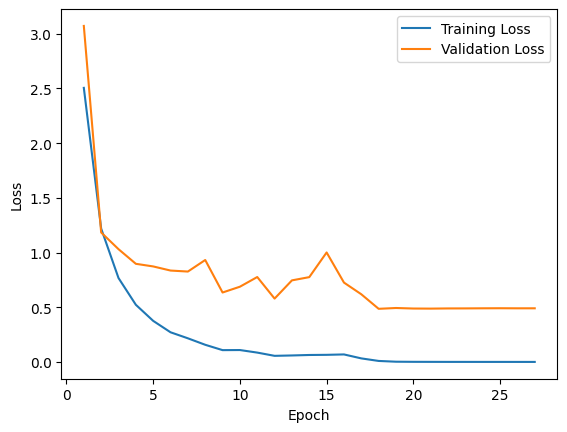

In [97]:
model, pred_list, label_list = main()

Results using the model introduced in the paper:

In [98]:
true_codes, predicted_codes = plot_label_distribution(pred_list, label_list)

In [159]:
fig, axis = plt.subplots(2, 5, figsize=(9, 6))

for ax in axis.flat:
    i = np.random.randint(len(labels))
    ax.imshow(test_ds[i][0][0,:,:], cmap='gray')

    assert int_to_label[test_ds[i][1]] ==  true_codes[i]
    
    ax.set(title=f'True: {int_to_label[test_ds[i][1]]}\nPredicted: {predicted_codes[i]}')
    ax.set_axis_off()
plt.show()

In [100]:
print(classification_report(y_true=true_codes, y_pred=predicted_codes, zero_division=0))

              precision    recall  f1-score   support

        Aa26       1.00      1.00      1.00         1
        Aa28       0.00      0.00      0.00         1
         D10       0.00      0.00      0.00         1
        D156       0.00      0.00      0.00         1
         D19       0.00      0.00      0.00         1
          D2       0.00      0.00      0.00         1
         D21       0.91      1.00      0.95        20
         D35       1.00      1.00      1.00         7
         D36       1.00      1.00      1.00        10
          D4       1.00      1.00      1.00         3
         D46       1.00      0.89      0.94         9
         D52       0.00      0.00      0.00         0
         D53       0.00      0.00      0.00         1
         D58       0.83      1.00      0.91        10
         E23       1.00      1.00      1.00         2
         E34       1.00      1.00      1.00        19
          E9       1.00      1.00      1.00         1
         F12       0.00    

### Perfromance on the 40 most popular labels:

In [101]:
target = ['D2', 'D21', 'D36', 'D4', 'D46', 'D58', 'E23', 'E34', 'F31', 'F35', 'G1', 'G17','G43', 'I10', 'I9', 'M17', 'M23', 'N35', 'O1', 'O34', 'O4', 'O49', 'Q1', 'Q3','R4', 'R8', 'S29', 'S34', 'U7', 'V13', 'V28', 'V30', 'V31', 'W11', 'W24', 'X1','X8', 'Y1', 'Y5', 'Z1']

report = classification_report(y_true=true_codes, y_pred=predicted_codes, zero_division=0, output_dict=True)

In [102]:
# Filter the report dictionary to keep only the desired keys
filtered_report = {key: value for key, value in report.items() if key in target}


overall_metrics = ['accuracy', 'macro avg', 'weighted avg']
filtered_report.update({key: report[key] for key in overall_metrics if key in report})

# Convert the filtered report to a pandas DataFrame
df = pd.DataFrame.from_dict(filtered_report).transpose()

# Print the DataFrame in a table format
print(df)

              precision    recall  f1-score    support
D2             0.000000  0.000000  0.000000    1.00000
D21            0.909091  1.000000  0.952381   20.00000
D36            1.000000  1.000000  1.000000   10.00000
D4             1.000000  1.000000  1.000000    3.00000
D46            1.000000  0.888889  0.941176    9.00000
D58            0.833333  1.000000  0.909091   10.00000
E23            1.000000  1.000000  1.000000    2.00000
E34            1.000000  1.000000  1.000000   19.00000
F31            1.000000  1.000000  1.000000    1.00000
G1             1.000000  0.428571  0.600000    7.00000
G17            0.933333  1.000000  0.965517   28.00000
G43            0.950000  1.000000  0.974359   19.00000
I10            1.000000  1.000000  1.000000    5.00000
I9             0.965517  1.000000  0.982456   28.00000
M17            0.888889  1.000000  0.941176   56.00000
M23            1.000000  1.000000  1.000000    3.00000
N35            0.983333  0.983333  0.983333   60.00000
O1        

In [103]:
# Filter out the 'accuracy', 'macro avg', and 'weighted avg' rows
metrics_df = df.drop(index=overall_metrics, errors='ignore')

# Calculate the averages of precision, recall, and f1-score
average_precision = metrics_df['precision'].mean()
average_recall = metrics_df['recall'].mean()
average_f1 = metrics_df['f1-score'].mean()

# Print the averages
print("\nAverages (excluding 'accuracy', 'macro avg', and 'weighted avg'):")
print(f"Average Precision: {average_precision:.4f}")
print(f"Average Recall: {average_recall:.4f}")
print(f"Average F1-Score: {average_f1:.4f}")


Averages (excluding 'accuracy', 'macro avg', and 'weighted avg'):
Average Precision: 0.8808
Average Recall: 0.9084
Average F1-Score: 0.8866


In [106]:
filtered_true_codes = [true_codes[i] for i in range(len(true_codes)) if true_codes[i] in target]
filtered_predicted_codes = [predicted_codes[i] for i in range(len(predicted_codes)) if true_codes[i] in target]

# Calculate accuracy
correct_predictions = sum(1 for true, pred in zip(filtered_true_codes, filtered_predicted_codes) if true == pred)
total_predictions = len(filtered_true_codes)
accuracy = correct_predictions / total_predictions

print(f"Accuracy for selected codes: {accuracy:.2%}")

Accuracy for selected codes: 97.91%


In [107]:
del model

# Model: Data oversampling

In [108]:
# Setup Train Loader
train_ds = Glyph_Dataset(dataset_path="GlyphDataset/Train",
                         label_encoder_file='label_encoding.json',
                         transform=transform,
                         augmentation=None, 
                         preprocessing=None,
                         oversample_factor=0.1)

print("Length of oversampled data: ",len(train_ds))

train_loader = DataLoader(train_ds,
                          batch_size=BATCH_SIZE,
                          num_workers=NUM_WORKERS,
                          shuffle=SHUFFLE)

# Setup Valid Loader
val_ds = Glyph_Dataset(dataset_path="GlyphDataset/Validation",
                        label_encoder_file='label_encoding.json',
                        transform=transform,
                        augmentation=None, 
                        preprocessing=None)

val_loader = DataLoader(val_ds,
                          batch_size=BATCH_SIZE,
                          num_workers=NUM_WORKERS,
                          shuffle=SHUFFLE)

# Setup Test Loader
test_ds = Glyph_Dataset(dataset_path="GlyphDataset/Test",
                         label_encoder_file='label_encoding.json',
                         transform=transform,
                         augmentation=None, 
                         preprocessing=None)

test_loader = DataLoader(test_ds,
                          batch_size=BATCH_SIZE,
                          num_workers=NUM_WORKERS,
                          shuffle=SHUFFLE)

Length of oversampled data:  5892


In [109]:
images, labels = next(iter(train_loader))

In [110]:
# Get labels from the oversampled dataset
oversampled_labels = []
for filename in train_ds.balanced_filenames:
    last_underscore_index = filename.rfind('_')
    label = filename[last_underscore_index+1:filename.rfind('.')]
    oversampled_labels.append(label)

# Count occurrences of each label
codes, counts = np.unique(oversampled_labels, return_counts=True)

# Sort the counts
sorted_indices = np.argsort(counts)
sorted_codes = codes[sorted_indices]
sorted_counts = counts[sorted_indices]

# Optionally exclude the lowest counts from the plot
exclusion_count = 130
filtered_codes = sorted_codes[exclusion_count:]
filtered_counts = sorted_counts[exclusion_count:]

# Create the bar chart with filtered data
fig = px.bar(
    x=filtered_counts, 
    y=filtered_codes,
    orientation='h',
    labels={'x': 'Count', 'y': 'Codes'},
    title='Horizontal Bar Chart of Codes'
)

# Update layout and show the plot
fig.update_layout(
    autosize=False,
    width=1000,
    height=1200
)
fig.show()

In [122]:
model = ATCNet(num_classes=172)

Epoch 1/50
Current learning rate: 0.001


100%|██████████| 99/99 [00:02<00:00, 41.97it/s, loss=4.76]


Avg. Validation loss: 3.6349772691726683 Avg. Training loss: 4.761301230902624
=> Saving checkpoint
Epoch 2/50
Current learning rate: 0.001


100%|██████████| 99/99 [00:02<00:00, 42.24it/s, loss=4.16]


Avg. Validation loss: 2.4201541781425475 Avg. Training loss: 3.789123366577457
=> Saving checkpoint
Epoch 3/50
Current learning rate: 0.001


100%|██████████| 99/99 [00:02<00:00, 41.87it/s, loss=3.53]


Avg. Validation loss: 1.6019768476486207 Avg. Training loss: 3.10081954797109
=> Saving checkpoint
Epoch 4/50
Current learning rate: 0.001


100%|██████████| 99/99 [00:02<00:00, 42.99it/s, loss=2.86]


Avg. Validation loss: 1.419945192337036 Avg. Training loss: 2.590457645329562
=> Saving checkpoint
Epoch 5/50
Current learning rate: 0.001


100%|██████████| 99/99 [00:02<00:00, 42.80it/s, loss=2.26]


Avg. Validation loss: 1.618474006652832 Avg. Training loss: 2.2110454686964403
=> Saving checkpoint
Epoch 6/50
Current learning rate: 0.001


100%|██████████| 99/99 [00:02<00:00, 39.65it/s, loss=1.58]


Avg. Validation loss: 1.4830850541591645 Avg. Training loss: 1.861536766543533
=> Saving checkpoint
Epoch 7/50
Current learning rate: 0.001


100%|██████████| 99/99 [00:02<00:00, 41.39it/s, loss=1.05] 


Avg. Validation loss: 1.5531457901000976 Avg. Training loss: 1.5366517853255224
=> Saving checkpoint
Epoch 8/50
Current learning rate: 0.001


100%|██████████| 99/99 [00:02<00:00, 41.11it/s, loss=0.644]


Avg. Validation loss: 1.7990832448005676 Avg. Training loss: 1.2479087559863775
=> Saving checkpoint
Epoch 9/50
Current learning rate: 0.0005


100%|██████████| 99/99 [00:02<00:00, 41.26it/s, loss=0.243]


Avg. Validation loss: 0.9925396621227265 Avg. Training loss: 0.9107065342291437
=> Saving checkpoint
Epoch 10/50
Current learning rate: 0.0005


100%|██████████| 99/99 [00:02<00:00, 41.05it/s, loss=0.165]


Avg. Validation loss: 0.8345435053110123 Avg. Training loss: 0.6203378326062
=> Saving checkpoint
Epoch 11/50
Current learning rate: 0.0005


100%|██████████| 99/99 [00:02<00:00, 42.27it/s, loss=0.095] 


Avg. Validation loss: 0.7494933068752289 Avg. Training loss: 0.41100255723553475
=> Saving checkpoint
Epoch 12/50
Current learning rate: 0.0005


100%|██████████| 99/99 [00:02<00:00, 42.57it/s, loss=0.0673]


Avg. Validation loss: 0.7224572449922562 Avg. Training loss: 0.2684576267922165
=> Saving checkpoint
Epoch 13/50
Current learning rate: 0.0005


100%|██████████| 99/99 [00:02<00:00, 42.62it/s, loss=0.0564]


Avg. Validation loss: 0.6676700994372368 Avg. Training loss: 0.18334994988158496
=> Saving checkpoint
Epoch 14/50
Current learning rate: 0.0005


100%|██████████| 99/99 [00:02<00:00, 41.28it/s, loss=0.0335]


Avg. Validation loss: 0.697008591890335 Avg. Training loss: 0.12284518620281508
=> Saving checkpoint
Epoch 15/50
Current learning rate: 0.0005


100%|██████████| 99/99 [00:02<00:00, 41.69it/s, loss=0.0319]


Avg. Validation loss: 0.6801333039999008 Avg. Training loss: 0.08551037866584581
=> Saving checkpoint
Epoch 16/50
Current learning rate: 0.0005


100%|██████████| 99/99 [00:02<00:00, 42.31it/s, loss=0.0202]


Avg. Validation loss: 0.6788850784301758 Avg. Training loss: 0.062418186115195055
=> Saving checkpoint
Epoch 17/50
Current learning rate: 0.0005


100%|██████████| 99/99 [00:02<00:00, 39.70it/s, loss=0.0196]


Avg. Validation loss: 0.6787221997976303 Avg. Training loss: 0.047258182833291064
=> Saving checkpoint
Epoch 18/50
Current learning rate: 0.00025


100%|██████████| 99/99 [00:02<00:00, 42.24it/s, loss=0.0147]


Avg. Validation loss: 0.666584424674511 Avg. Training loss: 0.03684080910464429
=> Saving checkpoint
Epoch 19/50
Current learning rate: 0.00025


100%|██████████| 99/99 [00:02<00:00, 40.93it/s, loss=0.0126]


Avg. Validation loss: 0.6732643559575081 Avg. Training loss: 0.03135998675957172
=> Saving checkpoint
Epoch 20/50
Current learning rate: 0.00025


100%|██████████| 99/99 [00:02<00:00, 41.02it/s, loss=0.015] 


Avg. Validation loss: 0.6707888379693031 Avg. Training loss: 0.027442796334549033
=> Saving checkpoint
Epoch 21/50
Current learning rate: 0.00025


100%|██████████| 99/99 [00:02<00:00, 40.13it/s, loss=0.0122] 


Avg. Validation loss: 0.676541231572628 Avg. Training loss: 0.02394210413625144
=> Saving checkpoint
Epoch 22/50
Current learning rate: 0.00025


100%|██████████| 99/99 [00:02<00:00, 41.26it/s, loss=0.0134] 


Avg. Validation loss: 0.6744969457387924 Avg. Training loss: 0.02142765744579862
=> Saving checkpoint
Epoch 23/50
Current learning rate: 0.000125


100%|██████████| 99/99 [00:02<00:00, 40.65it/s, loss=0.013]  


Avg. Validation loss: 0.6691004231572151 Avg. Training loss: 0.019696989308365366
=> Saving checkpoint
Epoch 24/50
Current learning rate: 0.000125


100%|██████████| 99/99 [00:02<00:00, 40.76it/s, loss=0.0108] 


Avg. Validation loss: 0.6674715787172317 Avg. Training loss: 0.018589638032470688
=> Saving checkpoint
Epoch 25/50
Current learning rate: 0.000125


100%|██████████| 99/99 [00:02<00:00, 41.63it/s, loss=0.0128] 


Avg. Validation loss: 0.6688920944929123 Avg. Training loss: 0.017284338287256583
=> Saving checkpoint
Epoch 26/50
Current learning rate: 0.000125


100%|██████████| 99/99 [00:02<00:00, 41.87it/s, loss=0.00994]


Avg. Validation loss: 0.6715712696313858 Avg. Training loss: 0.01668568922564237
=> Saving checkpoint
Epoch 27/50
Current learning rate: 6.25e-05


100%|██████████| 99/99 [00:02<00:00, 41.69it/s, loss=0.00838]


Avg. Validation loss: 0.6708090260624886 Avg. Training loss: 0.015468717317539031
=> Saving checkpoint
Epoch 28/50
Current learning rate: 6.25e-05


100%|██████████| 99/99 [00:02<00:00, 40.82it/s, loss=0.00716]


Avg. Validation loss: 0.6722978740930557 Avg. Training loss: 0.015094484315451347
Early Stopping


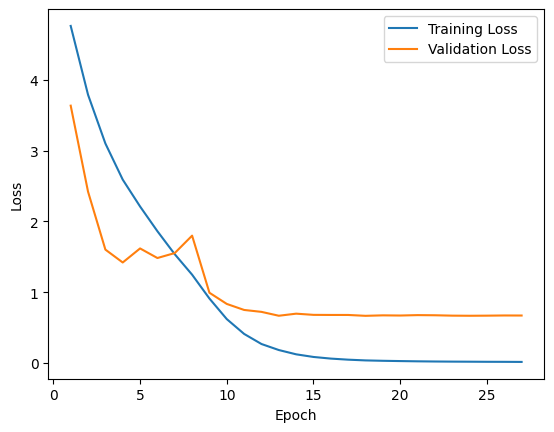

In [123]:
model, pred_list, label_list = main()

Results of the oversampled model:

In [124]:
true_codes, predicted_codes = plot_label_distribution(pred_list, label_list)

In [130]:
print(classification_report(y_true=true_codes, y_pred=predicted_codes, zero_division=0))

              precision    recall  f1-score   support

        Aa15       0.00      0.00      0.00         0
        Aa26       1.00      1.00      1.00         1
        Aa28       0.00      0.00      0.00         1
         D10       0.00      0.00      0.00         1
        D156       0.00      0.00      0.00         1
         D19       0.00      0.00      0.00         1
          D2       0.00      0.00      0.00         1
         D21       0.95      1.00      0.98        20
         D35       1.00      1.00      1.00         7
         D36       0.91      1.00      0.95        10
          D4       1.00      1.00      1.00         3
         D46       0.89      0.89      0.89         9
         D52       0.00      0.00      0.00         0
         D53       0.00      0.00      0.00         1
         D58       1.00      1.00      1.00        10
         E17       0.00      0.00      0.00         0
         E23       1.00      1.00      1.00         2
         E34       1.00    

In [132]:
target = ['D2', 'D21', 'D36', 'D4', 'D46', 'D58', 'E23', 'E34', 'F31', 'F35', 'G1', 'G17','G43', 'I10', 'I9', 'M17', 'M23', 'N35', 'O1', 'O34', 'O4', 'O49', 'Q1', 'Q3','R4', 'R8', 'S29', 'S34', 'U7', 'V13', 'V28', 'V30', 'V31', 'W11', 'W24', 'X1','X8', 'Y1', 'Y5', 'Z1']

report = classification_report(y_true=true_codes, y_pred=predicted_codes, zero_division=0, output_dict=True)

In [133]:
# Filter the report dictionary to keep only the desired keys
filtered_report = {key: value for key, value in report.items() if key in target}

# If you want to include overall metrics (like accuracy, macro avg, etc.), you can add them explicitly
overall_metrics = ['accuracy', 'macro avg', 'weighted avg']
filtered_report.update({key: report[key] for key in overall_metrics if key in report})

# Convert the filtered report to a pandas DataFrame
df = pd.DataFrame.from_dict(filtered_report).transpose()

# Print the DataFrame in a table format
print(df)

              precision    recall  f1-score     support
D2             0.000000  0.000000  0.000000    1.000000
D21            0.952381  1.000000  0.975610   20.000000
D36            0.909091  1.000000  0.952381   10.000000
D4             1.000000  1.000000  1.000000    3.000000
D46            0.888889  0.888889  0.888889    9.000000
D58            1.000000  1.000000  1.000000   10.000000
E23            1.000000  1.000000  1.000000    2.000000
E34            1.000000  1.000000  1.000000   19.000000
F31            1.000000  1.000000  1.000000    1.000000
G1             0.500000  0.285714  0.363636    7.000000
G17            0.933333  1.000000  0.965517   28.000000
G43            0.950000  1.000000  0.974359   19.000000
I10            1.000000  1.000000  1.000000    5.000000
I9             1.000000  0.964286  0.981818   28.000000
M17            0.846154  0.982143  0.909091   56.000000
M23            0.750000  1.000000  0.857143    3.000000
N35            0.967213  0.983333  0.975207   60

In [134]:
# Filter out the 'accuracy', 'macro avg', and 'weighted avg' rows
metrics_df = df.drop(index=overall_metrics, errors='ignore')

# Calculate the averages of precision, recall, and f1-score
average_precision = metrics_df['precision'].mean()
average_recall = metrics_df['recall'].mean()
average_f1 = metrics_df['f1-score'].mean()

# Print the averages
print("\nAverages (excluding 'accuracy', 'macro avg', and 'weighted avg'):")
print(f"Average Precision: {average_precision:.4f}")
print(f"Average Recall: {average_recall:.4f}")
print(f"Average F1-Score: {average_f1:.4f}")


Averages (excluding 'accuracy', 'macro avg', and 'weighted avg'):
Average Precision: 0.8096
Average Recall: 0.8226
Average F1-Score: 0.8053


In [135]:
filtered_true_codes = [true_codes[i] for i in range(len(true_codes)) if true_codes[i] in target]
filtered_predicted_codes = [predicted_codes[i] for i in range(len(predicted_codes)) if true_codes[i] in target]

# Calculate accuracy
correct_predictions = sum(1 for true, pred in zip(filtered_true_codes, filtered_predicted_codes) if true == pred)
total_predictions = len(filtered_true_codes)
accuracy = correct_predictions / total_predictions

print(f"Accuracy for selected codes: {accuracy:.2%}")

Accuracy for selected codes: 95.35%


In [136]:
del model

# Model: Transfer Learning

Use a pre-trained model such as ResNet50 to classify the labels.

In [137]:
# Load a pre-trained ResNet model
model = models.resnet50(pretrained=True)

# Modify the first convolutional layer to accept one channel
model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

# Copy the weights from the original 3-channel conv1 layer to the new layer
pretrained_weights = models.resnet50(pretrained=True).conv1.weight.data
model.conv1.weight.data = pretrained_weights.mean(dim=1, keepdim=True)

num_classes = 172
model.fc = nn.Linear(model.fc.in_features, num_classes)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning:

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning:

Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.



In [138]:
# Setup Train Loader
train_ds = Glyph_Dataset(dataset_path="GlyphDataset/Train",
                         label_encoder_file='label_encoding.json',
                         transform=transform,
                         augmentation=None, 
                         preprocessing=None)

print("Length of training data: ",len(train_ds))

train_loader = DataLoader(train_ds,
                          batch_size=BATCH_SIZE,
                          num_workers=NUM_WORKERS,
                          shuffle=SHUFFLE)

# Setup Valid Loader
val_ds = Glyph_Dataset(dataset_path="GlyphDataset/Validation",
                        label_encoder_file='label_encoding.json',
                        transform=transform,
                        augmentation=None, 
                        preprocessing=None)

val_loader = DataLoader(val_ds,
                          batch_size=BATCH_SIZE,
                          num_workers=NUM_WORKERS,
                          shuffle=SHUFFLE)

# Setup Test Loader
test_ds = Glyph_Dataset(dataset_path="GlyphDataset/Test",
                         label_encoder_file='label_encoding.json',
                         transform=transform,
                         augmentation=None, 
                         preprocessing=None)

test_loader = DataLoader(test_ds,
                          batch_size=BATCH_SIZE,
                          num_workers=NUM_WORKERS,
                          shuffle=SHUFFLE)

Length of training data:  2906


Epoch 1/50
Current learning rate: 0.001


100%|██████████| 49/49 [00:01<00:00, 34.14it/s, loss=1.6] 


Avg. Validation loss: 2.566452145576477 Avg. Training loss: 2.4699421415523606
=> Saving checkpoint
Epoch 2/50
Current learning rate: 0.001


100%|██████████| 49/49 [00:01<00:00, 35.37it/s, loss=0.977]


Avg. Validation loss: 1.1121151506900788 Avg. Training loss: 1.2175716709117501
=> Saving checkpoint
Epoch 3/50
Current learning rate: 0.001


100%|██████████| 49/49 [00:01<00:00, 37.69it/s, loss=0.682]


Avg. Validation loss: 0.9446432411670684 Avg. Training loss: 0.7843367974368893
=> Saving checkpoint
Epoch 4/50
Current learning rate: 0.001


100%|██████████| 49/49 [00:01<00:00, 38.88it/s, loss=0.446]


Avg. Validation loss: 0.9087987154722214 Avg. Training loss: 0.528549329966915
=> Saving checkpoint
Epoch 5/50
Current learning rate: 0.001


100%|██████████| 49/49 [00:01<00:00, 37.84it/s, loss=0.284]


Avg. Validation loss: 0.855421531200409 Avg. Training loss: 0.37083433325193366
=> Saving checkpoint
Epoch 6/50
Current learning rate: 0.001


100%|██████████| 49/49 [00:01<00:00, 37.61it/s, loss=0.17] 


Avg. Validation loss: 0.7534939348697662 Avg. Training loss: 0.2530492849800052
=> Saving checkpoint
Epoch 7/50
Current learning rate: 0.001


100%|██████████| 49/49 [00:01<00:00, 37.19it/s, loss=0.156] 


Avg. Validation loss: 0.587123554944992 Avg. Training loss: 0.18974231594071098
=> Saving checkpoint
Epoch 8/50
Current learning rate: 0.001


100%|██████████| 49/49 [00:01<00:00, 34.76it/s, loss=0.0987]


Avg. Validation loss: 0.6507258921861648 Avg. Training loss: 0.13754786877911918
=> Saving checkpoint
Epoch 9/50
Current learning rate: 0.001


100%|██████████| 49/49 [00:01<00:00, 38.42it/s, loss=0.0243]


Avg. Validation loss: 0.5833212792873382 Avg. Training loss: 0.08415079709826684
=> Saving checkpoint
Epoch 10/50
Current learning rate: 0.001


100%|██████████| 49/49 [00:01<00:00, 38.31it/s, loss=0.0313]


Avg. Validation loss: 0.6942600682377815 Avg. Training loss: 0.05487957995917116
=> Saving checkpoint
Epoch 11/50
Current learning rate: 0.001


100%|██████████| 49/49 [00:01<00:00, 38.72it/s, loss=0.121] 


Avg. Validation loss: 0.7564709097146988 Avg. Training loss: 0.0753234572784633
=> Saving checkpoint
Epoch 12/50
Current learning rate: 0.001


100%|██████████| 49/49 [00:01<00:00, 37.47it/s, loss=0.0271]


Avg. Validation loss: 0.5917044922709465 Avg. Training loss: 0.08392981379007806
=> Saving checkpoint
Epoch 13/50
Current learning rate: 0.001


100%|██████████| 49/49 [00:01<00:00, 38.82it/s, loss=0.00564]


Avg. Validation loss: 0.5643937408924102 Avg. Training loss: 0.055572645643687975
=> Saving checkpoint
Epoch 14/50
Current learning rate: 0.001


100%|██████████| 49/49 [00:01<00:00, 37.86it/s, loss=0.0152] 


Avg. Validation loss: 0.6610371962189674 Avg. Training loss: 0.043984406513675134
=> Saving checkpoint
Epoch 15/50
Current learning rate: 0.001


100%|██████████| 49/49 [00:01<00:00, 38.08it/s, loss=0.143]  


Avg. Validation loss: 0.7330682300031185 Avg. Training loss: 0.04522788475210569
=> Saving checkpoint
Epoch 16/50
Current learning rate: 0.001


100%|██████████| 49/49 [00:01<00:00, 38.70it/s, loss=0.106] 


Avg. Validation loss: 0.8874201297760009 Avg. Training loss: 0.06298081814406478
=> Saving checkpoint
Epoch 17/50
Current learning rate: 0.001


100%|██████████| 49/49 [00:01<00:00, 38.72it/s, loss=0.0284]


Avg. Validation loss: 0.6037087276577949 Avg. Training loss: 0.06914704412754093
=> Saving checkpoint
Epoch 18/50
Current learning rate: 0.0005


100%|██████████| 49/49 [00:01<00:00, 37.92it/s, loss=0.0198] 


Avg. Validation loss: 0.555570537596941 Avg. Training loss: 0.040511069306153426
=> Saving checkpoint
Epoch 19/50
Current learning rate: 0.0005


100%|██████████| 49/49 [00:01<00:00, 38.64it/s, loss=0.00148]


Avg. Validation loss: 0.4685765039175749 Avg. Training loss: 0.011826428114341534
=> Saving checkpoint
Epoch 20/50
Current learning rate: 0.0005


100%|██████████| 49/49 [00:01<00:00, 38.51it/s, loss=0.00147]


Avg. Validation loss: 0.4524914540350437 Avg. Training loss: 0.007171012926846743
=> Saving checkpoint
Epoch 21/50
Current learning rate: 0.0005


100%|██████████| 49/49 [00:01<00:00, 38.73it/s, loss=0.000994]


Avg. Validation loss: 0.46436514928936956 Avg. Training loss: 0.0027005377532058985
=> Saving checkpoint
Epoch 22/50
Current learning rate: 0.0005


100%|██████████| 49/49 [00:01<00:00, 37.97it/s, loss=0.00093] 


Avg. Validation loss: 0.45023182183504107 Avg. Training loss: 0.0017218854948308092
=> Saving checkpoint
Epoch 23/50
Current learning rate: 0.0005


100%|██████████| 49/49 [00:01<00:00, 39.05it/s, loss=0.000656]


Avg. Validation loss: 0.4479690480977297 Avg. Training loss: 0.0012137074705346354
=> Saving checkpoint
Epoch 24/50
Current learning rate: 0.0005


100%|██████████| 49/49 [00:01<00:00, 36.98it/s, loss=0.00065] 


Avg. Validation loss: 0.44835960157215593 Avg. Training loss: 0.001065773244386501
=> Saving checkpoint
Epoch 25/50
Current learning rate: 0.0005


100%|██████████| 49/49 [00:01<00:00, 38.17it/s, loss=0.000506]


Avg. Validation loss: 0.44668685346841813 Avg. Training loss: 0.0009435139565576552
=> Saving checkpoint
Epoch 26/50
Current learning rate: 0.0005


100%|██████████| 49/49 [00:01<00:00, 38.48it/s, loss=0.000484]


Avg. Validation loss: 0.4457784991711378 Avg. Training loss: 0.0008348654225059994
=> Saving checkpoint
Epoch 27/50
Current learning rate: 0.0005


100%|██████████| 49/49 [00:01<00:00, 35.51it/s, loss=0.000425]


Avg. Validation loss: 0.44535693526268005 Avg. Training loss: 0.0007831077851659181
=> Saving checkpoint
Epoch 28/50
Current learning rate: 0.0005


100%|██████████| 49/49 [00:01<00:00, 38.40it/s, loss=0.000656]


Avg. Validation loss: 0.4463014449924231 Avg. Training loss: 0.0007578264969420068
=> Saving checkpoint
Epoch 29/50
Current learning rate: 0.0005


100%|██████████| 49/49 [00:01<00:00, 38.28it/s, loss=0.000389]


Avg. Validation loss: 0.44694001972675323 Avg. Training loss: 0.0006744459150264002
=> Saving checkpoint
Epoch 30/50
Current learning rate: 0.0005


100%|██████████| 49/49 [00:01<00:00, 38.13it/s, loss=0.000634]


Avg. Validation loss: 0.4472532495856285 Avg. Training loss: 0.0006585793227565532
=> Saving checkpoint
Epoch 31/50
Current learning rate: 0.0005


100%|██████████| 49/49 [00:01<00:00, 39.24it/s, loss=0.000391]


Avg. Validation loss: 0.4480126701295376 Avg. Training loss: 0.0005733366700469003
=> Saving checkpoint
Epoch 32/50
Current learning rate: 0.00025


100%|██████████| 49/49 [00:01<00:00, 38.35it/s, loss=0.000481]


Avg. Validation loss: 0.4488765064626932 Avg. Training loss: 0.0005902617217079565
=> Saving checkpoint
Epoch 33/50
Current learning rate: 0.00025


100%|██████████| 49/49 [00:01<00:00, 38.79it/s, loss=0.000391]


Avg. Validation loss: 0.44897443875670434 Avg. Training loss: 0.0005403834125454708
=> Saving checkpoint
Epoch 34/50
Current learning rate: 0.00025


100%|██████████| 49/49 [00:01<00:00, 37.43it/s, loss=0.000398]


Avg. Validation loss: 0.44911851175129414 Avg. Training loss: 0.0005308847003663909
=> Saving checkpoint
Epoch 35/50
Current learning rate: 0.00025


100%|██████████| 49/49 [00:01<00:00, 39.02it/s, loss=0.000372]


Avg. Validation loss: 0.44892967231571673 Avg. Training loss: 0.0005192079400757745
=> Saving checkpoint
Epoch 36/50
Current learning rate: 0.000125


100%|██████████| 49/49 [00:01<00:00, 38.70it/s, loss=0.000345]


Avg. Validation loss: 0.4492056109011173 Avg. Training loss: 0.0005121950507971781
=> Saving checkpoint
Epoch 37/50
Current learning rate: 0.000125


100%|██████████| 49/49 [00:01<00:00, 37.25it/s, loss=0.000387]


Avg. Validation loss: 0.4492355637252331 Avg. Training loss: 0.0005152209291272626
Early Stopping


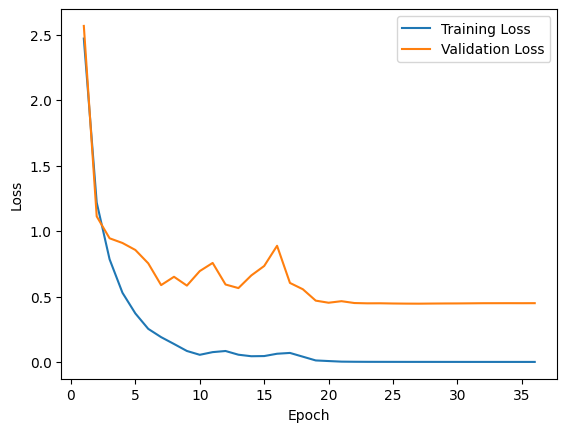

In [139]:
model, pred_list, label_list = main(model)

In [140]:
true_codes, predicted_codes = plot_label_distribution(pred_list, label_list)

In [141]:
print(classification_report(y_true=true_codes, y_pred=predicted_codes, zero_division=0))

              precision    recall  f1-score   support

        Aa26       1.00      1.00      1.00         1
        Aa28       0.00      0.00      0.00         1
         D10       0.00      0.00      0.00         1
        D156       0.00      0.00      0.00         1
         D19       0.00      0.00      0.00         1
          D2       0.00      0.00      0.00         1
         D21       0.95      1.00      0.98        20
         D28       0.00      0.00      0.00         0
         D35       1.00      1.00      1.00         7
         D36       1.00      1.00      1.00        10
          D4       1.00      1.00      1.00         3
         D46       1.00      0.89      0.94         9
         D53       0.00      0.00      0.00         1
         D58       0.91      1.00      0.95        10
         E23       1.00      1.00      1.00         2
         E34       1.00      1.00      1.00        19
          E9       1.00      1.00      1.00         1
         F12       0.00    

In [142]:
target = ['D2', 'D21', 'D36', 'D4', 'D46', 'D58', 'E23', 'E34', 'F31', 'F35', 'G1', 'G17','G43', 'I10', 'I9', 'M17', 'M23', 'N35', 'O1', 'O34', 'O4', 'O49', 'Q1', 'Q3','R4', 'R8', 'S29', 'S34', 'U7', 'V13', 'V28', 'V30', 'V31', 'W11', 'W24', 'X1','X8', 'Y1', 'Y5', 'Z1']

report = classification_report(y_true=true_codes, y_pred=predicted_codes, zero_division=0, output_dict=True)

In [143]:
# Filter the report dictionary to keep only the desired keys
filtered_report = {key: value for key, value in report.items() if key in target}

# If you want to include overall metrics (like accuracy, macro avg, etc.), you can add them explicitly
overall_metrics = ['accuracy', 'macro avg', 'weighted avg']
filtered_report.update({key: report[key] for key in overall_metrics if key in report})

# Convert the filtered report to a pandas DataFrame
df = pd.DataFrame.from_dict(filtered_report).transpose()

# Print the DataFrame in a table format
print(df)

              precision    recall  f1-score     support
D2             0.000000  0.000000  0.000000    1.000000
D21            0.952381  1.000000  0.975610   20.000000
D36            1.000000  1.000000  1.000000   10.000000
D4             1.000000  1.000000  1.000000    3.000000
D46            1.000000  0.888889  0.941176    9.000000
D58            0.909091  1.000000  0.952381   10.000000
E23            1.000000  1.000000  1.000000    2.000000
E34            1.000000  1.000000  1.000000   19.000000
F31            1.000000  1.000000  1.000000    1.000000
G1             0.600000  0.428571  0.500000    7.000000
G17            1.000000  1.000000  1.000000   28.000000
G43            0.950000  1.000000  0.974359   19.000000
I10            1.000000  1.000000  1.000000    5.000000
I9             1.000000  1.000000  1.000000   28.000000
M17            0.965517  1.000000  0.982456   56.000000
M23            0.750000  1.000000  0.857143    3.000000
N35            0.983333  0.983333  0.983333   60

In [144]:
# Filter out the 'accuracy', 'macro avg', and 'weighted avg' rows
metrics_df = df.drop(index=overall_metrics, errors='ignore')

# Calculate the averages of precision, recall, and f1-score
average_precision = metrics_df['precision'].mean()
average_recall = metrics_df['recall'].mean()
average_f1 = metrics_df['f1-score'].mean()

# Print the averages
print("\nAverages (excluding 'accuracy', 'macro avg', and 'weighted avg'):")
print(f"Average Precision: {average_precision:.4f}")
print(f"Average Recall: {average_recall:.4f}")
print(f"Average F1-Score: {average_f1:.4f}")


Averages (excluding 'accuracy', 'macro avg', and 'weighted avg'):
Average Precision: 0.8879
Average Recall: 0.9081
Average F1-Score: 0.8962


In [145]:
filtered_true_codes = [true_codes[i] for i in range(len(true_codes)) if true_codes[i] in target]
filtered_predicted_codes = [predicted_codes[i] for i in range(len(predicted_codes)) if true_codes[i] in target]

# Calculate accuracy
correct_predictions = sum(1 for true, pred in zip(filtered_true_codes, filtered_predicted_codes) if true == pred)
total_predictions = len(filtered_true_codes)
accuracy = correct_predictions / total_predictions

print(f"Accuracy for selected codes: {accuracy:.2%}")

Accuracy for selected codes: 97.91%


In [153]:
del model

# Model: Grid Search

Use grid search function to find optimal:
- Learning Rate
- Batch Size
- Shuffle

In [154]:
def grid_search(params):
    # Extract parameter values
    batch_sizes = params['BATCH_SIZE']
    shuffles = params['SHUFFLE']
    learning_rates = params['LEARNING_RATE']
    oversample_factors = params.get('OVERSAMPLE_FACTOR', [1.0])
    
    best_val_loss = float('inf')
    best_model = None
    best_params = None

    # Iterate through all combinations of hyperparameters
    for batch_size, shuffle, lr, oversample_factor in itertools.product(batch_sizes, shuffles, learning_rates, oversample_factors):
        print(f"Training with Batch Size: {batch_size}, Shuffle: {shuffle}, Learning Rate: {lr}, Oversample Factor: {oversample_factor}")

        # Setup Train Loader
        train_ds = Glyph_Dataset(dataset_path="GlyphDataset/Train",
                                 label_encoder_file='label_encoding.json',
                                 transform=transform,
                                 augmentation=None, 
                                 preprocessing=None,
                                 oversample_factor=oversample_factor)
        
        train_loader = DataLoader(train_ds,
                                  batch_size=batch_size,
                                  num_workers=NUM_WORKERS,
                                  shuffle=shuffle)

        # Setup Valid Loader
        val_ds = Glyph_Dataset(dataset_path="GlyphDataset/Validation",
                                label_encoder_file='label_encoding.json',
                                transform=transform,
                                augmentation=None, 
                                preprocessing=None)
        
        # Setup Valid Loader
        val_loader = DataLoader(val_ds,
                                batch_size=batch_size,
                                num_workers=NUM_WORKERS,
                                shuffle=shuffle)

        # Setup Test Loader
        test_ds = Glyph_Dataset(dataset_path="GlyphDataset/Test",
                                 label_encoder_file='label_encoding.json',
                                 transform=transform,
                                 augmentation=None, 
                                 preprocessing=None)

        # Setup Test Loader
        test_loader = DataLoader(test_ds,
                                 batch_size=batch_size,
                                 num_workers=NUM_WORKERS,
                                 shuffle=shuffle)

        # Initialize the model, loss function, optimizer, and scheduler
        model = ATCNet(num_classes=172).to(DEVICE)
        loss_fn = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, min_lr=1e-6)

        # Train and validate the model
        train_losses = []
        val_losses = []
        lowest_val_loss = float('inf')
        epochs_no_improvement = 0

        for epoch in range(NUM_EPOCHS):
            print(f"Epoch {epoch+1}/{NUM_EPOCHS}")
            loss = train_fn(train_loader, model, optimizer, loss_fn, DEVICE)
            val_loss = validate_fn(val_loader, model, loss_fn, DEVICE)
            print(f'Avg. Validation loss: {val_loss} Avg. Training loss: {loss}')

            if val_loss < lowest_val_loss:
                epochs_no_improvement = 0
                lowest_val_loss = val_loss
            else:
                epochs_no_improvement += 1

            if epochs_no_improvement == PATIENCE:
                print("Early Stopping")
                break

            train_losses.append(loss)
            val_losses.append(val_loss)
            scheduler.step(val_loss)

        # Check if this is the best model so far
        if lowest_val_loss < best_val_loss:
            best_val_loss = lowest_val_loss
            best_model = model
            best_params = {
                'BATCH_SIZE': batch_size,
                'SHUFFLE': shuffle,
                'LEARNING_RATE': lr,
                'OVERSAMPLE_FACTOR': oversample_factor
            }
            # Save the best model
            torch.save(best_model.state_dict(), "best_model.pth")
        del model

    print(f"Best Validation Loss: {best_val_loss}")
    print(f"Best Parameters: {best_params}")

    # Load the best model
    best_model.load_state_dict(torch.load("best_model.pth"))

    # Evaluate on the test set
    pred_list, label_list = save_predictions_and_labels(loader=test_loader, model=best_model, device=DEVICE)
    return best_model, pred_list, label_list, best_params

# Define parameters for grid search
params = {
    'BATCH_SIZE': [30, 60],
    'SHUFFLE': [False, True],
    'LEARNING_RATE': [1e-3, 1e-4],
    'OVERSAMPLE_FACTOR': [0, 0.05]
}

# Perform Grid Search
best_model, pred_list, label_list, best_params = grid_search(params)

Training with Batch Size: 30, Shuffle: False, Learning Rate: 0.001, Oversample Factor: 0
Epoch 1/50


100%|██████████| 97/97 [00:01<00:00, 56.46it/s, loss=1.4] 


Avg. Validation loss: 1.6222839731919139 Avg. Training loss: 2.3236106873787556
Epoch 2/50


100%|██████████| 97/97 [00:01<00:00, 57.56it/s, loss=0.942]


Avg. Validation loss: 1.1347826068338596 Avg. Training loss: 1.1192144702390296
Epoch 3/50


100%|██████████| 97/97 [00:01<00:00, 56.51it/s, loss=0.771]


Avg. Validation loss: 1.0701155678222054 Avg. Training loss: 0.7046545490468901
Epoch 4/50


100%|██████████| 97/97 [00:01<00:00, 54.94it/s, loss=0.475] 


Avg. Validation loss: 0.9766286799782201 Avg. Training loss: 0.48514826826213564
Epoch 5/50


100%|██████████| 97/97 [00:01<00:00, 56.14it/s, loss=0.373] 


Avg. Validation loss: 0.9192710534522408 Avg. Training loss: 0.36622133075269225
Epoch 6/50


100%|██████████| 97/97 [00:01<00:00, 57.73it/s, loss=0.289] 


Avg. Validation loss: 1.0054180935809487 Avg. Training loss: 0.27252423256328423
Epoch 7/50


100%|██████████| 97/97 [00:01<00:00, 52.93it/s, loss=0.195] 


Avg. Validation loss: 0.8284481430524274 Avg. Training loss: 0.21714196354150772
Epoch 8/50


100%|██████████| 97/97 [00:01<00:00, 52.86it/s, loss=0.254] 


Avg. Validation loss: 0.6990454800819096 Avg. Training loss: 0.15646356513205262
Epoch 9/50


100%|██████████| 97/97 [00:01<00:00, 56.09it/s, loss=0.1]   


Avg. Validation loss: 0.6817114910012797 Avg. Training loss: 0.12609649720342503
Epoch 10/50


100%|██████████| 97/97 [00:01<00:00, 54.82it/s, loss=0.0963]


Avg. Validation loss: 0.5457719999708628 Avg. Training loss: 0.10143274122599474
Epoch 11/50


100%|██████████| 97/97 [00:01<00:00, 55.31it/s, loss=0.059] 


Avg. Validation loss: 0.7147146428101941 Avg. Training loss: 0.06739496024920769
Epoch 12/50


100%|██████████| 97/97 [00:01<00:00, 55.41it/s, loss=0.0259] 


Avg. Validation loss: 0.8490479788497874 Avg. Training loss: 0.09508319223088395
Epoch 13/50


100%|██████████| 97/97 [00:01<00:00, 54.80it/s, loss=0.179]  


Avg. Validation loss: 0.7802848984536371 Avg. Training loss: 0.09624402253341276
Epoch 14/50


100%|██████████| 97/97 [00:01<00:00, 56.49it/s, loss=0.0885] 


Avg. Validation loss: 0.6806303427407616 Avg. Training loss: 0.07822573867136824
Epoch 15/50


100%|██████████| 97/97 [00:01<00:00, 56.28it/s, loss=0.0733] 


Avg. Validation loss: 0.5273010418995431 Avg. Training loss: 0.03619264157191303
Epoch 16/50


100%|██████████| 97/97 [00:01<00:00, 57.92it/s, loss=0.00167] 


Avg. Validation loss: 0.5392203332954332 Avg. Training loss: 0.014169042030488592
Epoch 17/50


100%|██████████| 97/97 [00:01<00:00, 55.17it/s, loss=0.00126] 


Avg. Validation loss: 0.48771767386872517 Avg. Training loss: 0.004177055655877807
Epoch 18/50


100%|██████████| 97/97 [00:01<00:00, 56.74it/s, loss=0.000943]


Avg. Validation loss: 0.5063625806452412 Avg. Training loss: 0.0022035940966122426
Epoch 19/50


100%|██████████| 97/97 [00:01<00:00, 57.61it/s, loss=0.000864]


Avg. Validation loss: 0.5043213228744111 Avg. Training loss: 0.0015623147618001538
Epoch 20/50


100%|██████████| 97/97 [00:01<00:00, 56.54it/s, loss=0.0007]  


Avg. Validation loss: 0.5025625992076177 Avg. Training loss: 0.0013051645162085687
Epoch 21/50


100%|██████████| 97/97 [00:01<00:00, 55.82it/s, loss=0.000622]


Avg. Validation loss: 0.5026629372058731 Avg. Training loss: 0.0011155483266098675
Epoch 22/50


100%|██████████| 97/97 [00:01<00:00, 56.80it/s, loss=0.000809]


Avg. Validation loss: 0.5032378924814495 Avg. Training loss: 0.0010058142076193634
Epoch 23/50


100%|██████████| 97/97 [00:01<00:00, 50.04it/s, loss=0.000759]


Avg. Validation loss: 0.5036430690241488 Avg. Training loss: 0.0009477693784367485
Epoch 24/50


100%|██████████| 97/97 [00:01<00:00, 55.28it/s, loss=0.000509]


Avg. Validation loss: 0.5037868967475859 Avg. Training loss: 0.0008384121861548844
Epoch 25/50


100%|██████████| 97/97 [00:01<00:00, 55.98it/s, loss=0.000679]


Avg. Validation loss: 0.5050367773265431 Avg. Training loss: 0.000862015449362759
Epoch 26/50


100%|██████████| 97/97 [00:01<00:00, 57.29it/s, loss=0.000761]


Avg. Validation loss: 0.5048083686514905 Avg. Training loss: 0.0007794896477038885
Epoch 27/50


100%|██████████| 97/97 [00:01<00:00, 55.52it/s, loss=0.000439]


Avg. Validation loss: 0.5043552711998162 Avg. Training loss: 0.0007705211793324555
Early Stopping
Training with Batch Size: 30, Shuffle: False, Learning Rate: 0.001, Oversample Factor: 0.05
Epoch 1/50


100%|██████████| 135/135 [00:02<00:00, 57.16it/s, loss=5]   


Avg. Validation loss: 2.0238013079291894 Avg. Training loss: 3.75319152408176
Epoch 2/50


100%|██████████| 135/135 [00:02<00:00, 57.92it/s, loss=4.42]


Avg. Validation loss: 1.4981224129074497 Avg. Training loss: 2.584829638622425
Epoch 3/50


100%|██████████| 135/135 [00:02<00:00, 58.03it/s, loss=3.42] 


Avg. Validation loss: 1.1780134455153817 Avg. Training loss: 1.99956937984184
Epoch 4/50


100%|██████████| 135/135 [00:02<00:00, 57.98it/s, loss=2.53] 


Avg. Validation loss: 0.9367980415883818 Avg. Training loss: 1.6140299792642947
Epoch 5/50


100%|██████████| 135/135 [00:02<00:00, 60.33it/s, loss=2.09] 


Avg. Validation loss: 1.02601799212004 Avg. Training loss: 1.3012207878960504
Epoch 6/50


100%|██████████| 135/135 [00:02<00:00, 57.37it/s, loss=1.08] 


Avg. Validation loss: 0.9633613464079405 Avg. Training loss: 1.06048338148329
Epoch 7/50


100%|██████████| 135/135 [00:02<00:00, 57.28it/s, loss=0.677]


Avg. Validation loss: 1.0593139505700062 Avg. Training loss: 0.8181471628171426
Epoch 8/50


100%|██████████| 135/135 [00:02<00:00, 57.99it/s, loss=0.318]


Avg. Validation loss: 1.1298212659986395 Avg. Training loss: 0.6426975039420304
Epoch 9/50


100%|██████████| 135/135 [00:02<00:00, 54.16it/s, loss=0.157]


Avg. Validation loss: 0.7058390515219224 Avg. Training loss: 0.38826554163738536
Epoch 10/50


100%|██████████| 135/135 [00:02<00:00, 57.30it/s, loss=0.121] 


Avg. Validation loss: 0.636840325486111 Avg. Training loss: 0.1937118127528164
Epoch 11/50


100%|██████████| 135/135 [00:02<00:00, 57.20it/s, loss=0.0518]


Avg. Validation loss: 0.617030091044542 Avg. Training loss: 0.1017563949442572
Epoch 12/50


100%|██████████| 135/135 [00:02<00:00, 58.43it/s, loss=0.0402]


Avg. Validation loss: 0.6124361697584391 Avg. Training loss: 0.059515518777900275
Epoch 13/50


100%|██████████| 135/135 [00:02<00:00, 59.48it/s, loss=0.0302]


Avg. Validation loss: 0.6239884227122131 Avg. Training loss: 0.03923901796892837
Epoch 14/50


100%|██████████| 135/135 [00:02<00:00, 58.40it/s, loss=0.0365] 


Avg. Validation loss: 0.6073687702760493 Avg. Training loss: 0.02613956739919053
Epoch 15/50


100%|██████████| 135/135 [00:02<00:00, 57.85it/s, loss=0.0222] 


Avg. Validation loss: 0.6125752441094894 Avg. Training loss: 0.019564043244140017
Epoch 16/50


100%|██████████| 135/135 [00:02<00:00, 58.83it/s, loss=0.0131] 


Avg. Validation loss: 0.6057628018438423 Avg. Training loss: 0.014836576974226369
Epoch 17/50


100%|██████████| 135/135 [00:02<00:00, 59.26it/s, loss=0.0139] 


Avg. Validation loss: 0.6175775854897342 Avg. Training loss: 0.011315972670153888
Epoch 18/50


100%|██████████| 135/135 [00:02<00:00, 58.21it/s, loss=0.0153] 


Avg. Validation loss: 0.6078193041888115 Avg. Training loss: 0.009281965669382502
Epoch 19/50


100%|██████████| 135/135 [00:02<00:00, 58.00it/s, loss=0.014]  


Avg. Validation loss: 0.61388935521245 Avg. Training loss: 0.00766118594997183
Epoch 20/50


100%|██████████| 135/135 [00:02<00:00, 59.76it/s, loss=0.0094] 


Avg. Validation loss: 0.6132456708797499 Avg. Training loss: 0.0064859416111613865
Epoch 21/50


100%|██████████| 135/135 [00:02<00:00, 55.56it/s, loss=0.00763]


Avg. Validation loss: 0.611705990067046 Avg. Training loss: 0.005631439985396961
Epoch 22/50


100%|██████████| 135/135 [00:02<00:00, 57.43it/s, loss=0.00791]


Avg. Validation loss: 0.6091922464731493 Avg. Training loss: 0.005317822046129516
Epoch 23/50


100%|██████████| 135/135 [00:02<00:00, 57.66it/s, loss=0.00664]


Avg. Validation loss: 0.6117600874583188 Avg. Training loss: 0.004931438233944829
Epoch 24/50


100%|██████████| 135/135 [00:02<00:00, 57.39it/s, loss=0.00777]


Avg. Validation loss: 0.6121174842364302 Avg. Training loss: 0.004550590047923227
Epoch 25/50


100%|██████████| 135/135 [00:02<00:00, 59.03it/s, loss=0.00771]


Avg. Validation loss: 0.6114371240286058 Avg. Training loss: 0.004324843850918114
Epoch 26/50


100%|██████████| 135/135 [00:02<00:00, 58.90it/s, loss=0.00646]


Avg. Validation loss: 0.6118513478064224 Avg. Training loss: 0.0041336864491717685
Early Stopping
Training with Batch Size: 30, Shuffle: False, Learning Rate: 0.0001, Oversample Factor: 0
Epoch 1/50


100%|██████████| 97/97 [00:01<00:00, 55.79it/s, loss=2.42]


Avg. Validation loss: 2.3865501441453634 Avg. Training loss: 3.4536923256117045
Epoch 2/50


100%|██████████| 97/97 [00:01<00:00, 55.99it/s, loss=1.59]


Avg. Validation loss: 1.6856138580723812 Avg. Training loss: 1.974698811462245
Epoch 3/50


100%|██████████| 97/97 [00:01<00:00, 57.17it/s, loss=1.18] 


Avg. Validation loss: 1.4046169770391363 Avg. Training loss: 1.4010288580176757
Epoch 4/50


100%|██████████| 97/97 [00:01<00:00, 57.06it/s, loss=0.999]


Avg. Validation loss: 1.2418655659023083 Avg. Training loss: 1.0750051822858988
Epoch 5/50


100%|██████████| 97/97 [00:01<00:00, 56.81it/s, loss=0.906]


Avg. Validation loss: 1.13895803846811 Avg. Training loss: 0.8357038688413876
Epoch 6/50


100%|██████████| 97/97 [00:01<00:00, 55.95it/s, loss=0.785]


Avg. Validation loss: 1.0619868416535228 Avg. Training loss: 0.6480917377570241
Epoch 7/50


100%|██████████| 97/97 [00:01<00:00, 58.18it/s, loss=0.676]


Avg. Validation loss: 1.0094170021383386 Avg. Training loss: 0.504988664665173
Epoch 8/50


100%|██████████| 97/97 [00:01<00:00, 57.25it/s, loss=0.608]


Avg. Validation loss: 0.9684524332222185 Avg. Training loss: 0.3944248893519038
Epoch 9/50


100%|██████████| 97/97 [00:01<00:00, 50.57it/s, loss=0.479]


Avg. Validation loss: 0.9489360890890423 Avg. Training loss: 0.3082283656928957
Epoch 10/50


100%|██████████| 97/97 [00:01<00:00, 56.17it/s, loss=0.37]  


Avg. Validation loss: 0.932882735603734 Avg. Training loss: 0.2427555631423734
Epoch 11/50


100%|██████████| 97/97 [00:01<00:00, 56.21it/s, loss=0.293] 


Avg. Validation loss: 0.8892519803423631 Avg. Training loss: 0.18963193566989653
Epoch 12/50


100%|██████████| 97/97 [00:01<00:00, 56.80it/s, loss=0.21]  


Avg. Validation loss: 0.8502522644243742 Avg. Training loss: 0.14401136788049923
Epoch 13/50


100%|██████████| 97/97 [00:01<00:00, 58.45it/s, loss=0.147] 


Avg. Validation loss: 0.8268178670029891 Avg. Training loss: 0.11218838931358967
Epoch 14/50


100%|██████████| 97/97 [00:01<00:00, 57.46it/s, loss=0.0971]


Avg. Validation loss: 0.7862925207928607 Avg. Training loss: 0.08338132239494127
Epoch 15/50


100%|██████████| 97/97 [00:01<00:00, 56.68it/s, loss=0.0785]


Avg. Validation loss: 0.7637977356973448 Avg. Training loss: 0.06186508080086757
Epoch 16/50


100%|██████████| 97/97 [00:01<00:00, 55.00it/s, loss=0.0538]


Avg. Validation loss: 0.7480772592519459 Avg. Training loss: 0.047050766166798846
Epoch 17/50


100%|██████████| 97/97 [00:01<00:00, 55.71it/s, loss=0.0399]


Avg. Validation loss: 0.7419041277546632 Avg. Training loss: 0.03577527353904911
Epoch 18/50


100%|██████████| 97/97 [00:01<00:00, 57.64it/s, loss=0.0304]


Avg. Validation loss: 0.7283384321551574 Avg. Training loss: 0.029293339382665057
Epoch 19/50


100%|██████████| 97/97 [00:01<00:00, 57.24it/s, loss=0.0236] 


Avg. Validation loss: 0.7278046506015878 Avg. Training loss: 0.02299000584933254
Epoch 20/50


100%|██████████| 97/97 [00:01<00:00, 57.56it/s, loss=0.0194] 


Avg. Validation loss: 0.7211872903924239 Avg. Training loss: 0.0191850711053871
Epoch 21/50


100%|██████████| 97/97 [00:01<00:00, 55.48it/s, loss=0.019]  


Avg. Validation loss: 0.7213163289584612 Avg. Training loss: 0.016184070584431443
Epoch 22/50


100%|██████████| 97/97 [00:01<00:00, 56.78it/s, loss=0.0106] 


Avg. Validation loss: 0.716665484403309 Avg. Training loss: 0.013651327858919027
Epoch 23/50


100%|██████████| 97/97 [00:01<00:00, 56.36it/s, loss=0.0117] 


Avg. Validation loss: 0.7164778944693113 Avg. Training loss: 0.012071708678123877
Epoch 24/50


100%|██████████| 97/97 [00:01<00:00, 55.00it/s, loss=0.0127] 


Avg. Validation loss: 0.7155884876847267 Avg. Training loss: 0.010509991091820076
Epoch 25/50


100%|██████████| 97/97 [00:01<00:00, 54.27it/s, loss=0.00914]


Avg. Validation loss: 0.7131156101822853 Avg. Training loss: 0.0091455747114168
Epoch 26/50


100%|██████████| 97/97 [00:01<00:00, 55.34it/s, loss=0.00871]


Avg. Validation loss: 0.7084884788644942 Avg. Training loss: 0.008328057271092362
Epoch 27/50


100%|██████████| 97/97 [00:01<00:00, 57.24it/s, loss=0.0069] 


Avg. Validation loss: 0.7097403309062907 Avg. Training loss: 0.007590110648961104
Epoch 28/50


100%|██████████| 97/97 [00:01<00:00, 56.60it/s, loss=0.00622]


Avg. Validation loss: 0.7078738981171658 Avg. Training loss: 0.006749326015160102
Epoch 29/50


100%|██████████| 97/97 [00:01<00:00, 55.88it/s, loss=0.00621]


Avg. Validation loss: 0.7052907637859646 Avg. Training loss: 0.0060370889343513345
Epoch 30/50


100%|██████████| 97/97 [00:01<00:00, 55.40it/s, loss=0.00492]


Avg. Validation loss: 0.7073832962073778 Avg. Training loss: 0.005493166503621284
Epoch 31/50


100%|██████████| 97/97 [00:01<00:00, 55.24it/s, loss=0.00469]


Avg. Validation loss: 0.709584611811136 Avg. Training loss: 0.0049894790887621415
Epoch 32/50


100%|██████████| 97/97 [00:01<00:00, 55.73it/s, loss=0.00424]


Avg. Validation loss: 0.7095431536436081 Avg. Training loss: 0.004562772161173683
Epoch 33/50


100%|██████████| 97/97 [00:01<00:00, 56.33it/s, loss=0.00348]


Avg. Validation loss: 0.7103850406251455 Avg. Training loss: 0.004206008042602502
Epoch 34/50


100%|██████████| 97/97 [00:01<00:00, 56.95it/s, loss=0.00307]


Avg. Validation loss: 0.7036438396102503 Avg. Training loss: 0.003914499123695969
Epoch 35/50


100%|██████████| 97/97 [00:01<00:00, 56.70it/s, loss=0.00436]


Avg. Validation loss: 0.7041618812241053 Avg. Training loss: 0.0036337575191132646
Epoch 36/50


100%|██████████| 97/97 [00:01<00:00, 55.14it/s, loss=0.00339]


Avg. Validation loss: 0.705505171888753 Avg. Training loss: 0.0034783099065102715
Epoch 37/50


100%|██████████| 97/97 [00:01<00:00, 55.46it/s, loss=0.00339]


Avg. Validation loss: 0.702905426292043 Avg. Training loss: 0.0034115968185678587
Epoch 38/50


100%|██████████| 97/97 [00:01<00:00, 55.50it/s, loss=0.00391]


Avg. Validation loss: 0.7051431466090051 Avg. Training loss: 0.003213154047621971
Epoch 39/50


100%|██████████| 97/97 [00:01<00:00, 55.10it/s, loss=0.00271]


Avg. Validation loss: 0.7032260063447451 Avg. Training loss: 0.0030475022804145654
Epoch 40/50


100%|██████████| 97/97 [00:01<00:00, 52.05it/s, loss=0.0034] 


Avg. Validation loss: 0.7059669827944354 Avg. Training loss: 0.0029726706003559006
Epoch 41/50


100%|██████████| 97/97 [00:01<00:00, 58.80it/s, loss=0.00253]


Avg. Validation loss: 0.7046300168884428 Avg. Training loss: 0.002800452273300628
Epoch 42/50


100%|██████████| 97/97 [00:01<00:00, 57.08it/s, loss=0.00269]


Avg. Validation loss: 0.7047121030719656 Avg. Training loss: 0.00277747772273982
Epoch 43/50


100%|██████████| 97/97 [00:01<00:00, 56.93it/s, loss=0.00281]


Avg. Validation loss: 0.7042152065979806 Avg. Training loss: 0.002683563828804367
Epoch 44/50


100%|██████████| 97/97 [00:01<00:00, 55.97it/s, loss=0.00282]


Avg. Validation loss: 0.7048324393598657 Avg. Training loss: 0.002676045795729787
Epoch 45/50


100%|██████████| 97/97 [00:01<00:00, 56.86it/s, loss=0.0026] 


Avg. Validation loss: 0.7053090824108375 Avg. Training loss: 0.002589909176188569
Epoch 46/50


100%|██████████| 97/97 [00:01<00:00, 58.01it/s, loss=0.00206]


Avg. Validation loss: 0.7046092725113818 Avg. Training loss: 0.002463840191209324
Epoch 47/50


100%|██████████| 97/97 [00:01<00:00, 57.37it/s, loss=0.0028] 


Avg. Validation loss: 0.7054411031697926 Avg. Training loss: 0.0024093517627970305
Early Stopping
Training with Batch Size: 30, Shuffle: False, Learning Rate: 0.0001, Oversample Factor: 0.05
Epoch 1/50


100%|██████████| 135/135 [00:02<00:00, 58.25it/s, loss=5.11]


Avg. Validation loss: 2.731286964918438 Avg. Training loss: 4.171604836428607
Epoch 2/50


100%|██████████| 135/135 [00:02<00:00, 58.08it/s, loss=4.47]


Avg. Validation loss: 2.0714587475124158 Avg. Training loss: 3.1500230806845204
Epoch 3/50


100%|██████████| 135/135 [00:02<00:00, 57.20it/s, loss=3.89]


Avg. Validation loss: 1.6441676961748224 Avg. Training loss: 2.579626217594853
Epoch 4/50


100%|██████████| 135/135 [00:02<00:00, 59.12it/s, loss=3.15] 


Avg. Validation loss: 1.4403316033513922 Avg. Training loss: 2.150058994911335
Epoch 5/50


100%|██████████| 135/135 [00:02<00:00, 58.19it/s, loss=2.7]  


Avg. Validation loss: 1.313070977988996 Avg. Training loss: 1.7919664533049973
Epoch 6/50


100%|██████████| 135/135 [00:02<00:00, 59.09it/s, loss=2.22] 


Avg. Validation loss: 1.2212012990524894 Avg. Training loss: 1.4679657993493256
Epoch 7/50


100%|██████████| 135/135 [00:02<00:00, 56.46it/s, loss=1.81] 


Avg. Validation loss: 1.1542905678874569 Avg. Training loss: 1.1578618586063385
Epoch 8/50


100%|██████████| 135/135 [00:02<00:00, 59.88it/s, loss=1.41] 


Avg. Validation loss: 1.0839048576982397 Avg. Training loss: 0.8719930706200776
Epoch 9/50


100%|██████████| 135/135 [00:02<00:00, 58.96it/s, loss=1.03] 


Avg. Validation loss: 1.0344395527714176 Avg. Training loss: 0.6479186590071078
Epoch 10/50


100%|██████████| 135/135 [00:02<00:00, 58.06it/s, loss=0.848]


Avg. Validation loss: 0.9897472434922269 Avg. Training loss: 0.4720637572032434
Epoch 11/50


100%|██████████| 135/135 [00:02<00:00, 59.82it/s, loss=0.536]


Avg. Validation loss: 0.9609655941787519 Avg. Training loss: 0.34178364475568135
Epoch 12/50


100%|██████████| 135/135 [00:02<00:00, 58.79it/s, loss=0.439] 


Avg. Validation loss: 0.9285571920244318 Avg. Training loss: 0.24510078844096925
Epoch 13/50


100%|██████████| 135/135 [00:02<00:00, 59.15it/s, loss=0.314] 


Avg. Validation loss: 0.9094551189949638 Avg. Training loss: 0.17566482030131197
Epoch 14/50


100%|██████████| 135/135 [00:02<00:00, 58.28it/s, loss=0.248] 


Avg. Validation loss: 0.8790693737958607 Avg. Training loss: 0.13015953252712886
Epoch 15/50


100%|██████████| 135/135 [00:02<00:00, 58.99it/s, loss=0.187] 


Avg. Validation loss: 0.867439005719988 Avg. Training loss: 0.09880835521552297
Epoch 16/50


100%|██████████| 135/135 [00:02<00:00, 59.26it/s, loss=0.148] 


Avg. Validation loss: 0.847593281614153 Avg. Training loss: 0.07617490531669723
Epoch 17/50


100%|██████████| 135/135 [00:02<00:00, 58.57it/s, loss=0.119] 


Avg. Validation loss: 0.8218906466898165 Avg. Training loss: 0.06147332108683056
Epoch 18/50


100%|██████████| 135/135 [00:02<00:00, 58.60it/s, loss=0.0986]


Avg. Validation loss: 0.8100181786637557 Avg. Training loss: 0.0490310906674023
Epoch 19/50


100%|██████████| 135/135 [00:02<00:00, 53.50it/s, loss=0.0873]


Avg. Validation loss: 0.7911416111808074 Avg. Training loss: 0.040851830208191164
Epoch 20/50


100%|██████████| 135/135 [00:02<00:00, 59.89it/s, loss=0.0746]


Avg. Validation loss: 0.7826575162379366 Avg. Training loss: 0.0350967851501924
Epoch 21/50


100%|██████████| 135/135 [00:02<00:00, 58.27it/s, loss=0.059] 


Avg. Validation loss: 0.7792063939728235 Avg. Training loss: 0.029388271148006122
Epoch 22/50


100%|██████████| 135/135 [00:02<00:00, 58.50it/s, loss=0.0614]


Avg. Validation loss: 0.7732910584462317 Avg. Training loss: 0.025168643967696913
Epoch 23/50


100%|██████████| 135/135 [00:02<00:00, 60.12it/s, loss=0.0494] 


Avg. Validation loss: 0.7680094336208544 Avg. Training loss: 0.0219762257196837
Epoch 24/50


100%|██████████| 135/135 [00:02<00:00, 58.73it/s, loss=0.0444] 


Avg. Validation loss: 0.7627447200448889 Avg. Training loss: 0.018989468172744467
Epoch 25/50


100%|██████████| 135/135 [00:02<00:00, 58.53it/s, loss=0.04]   


Avg. Validation loss: 0.7649826779961586 Avg. Training loss: 0.016850815071827837
Epoch 26/50


100%|██████████| 135/135 [00:02<00:00, 58.45it/s, loss=0.0365] 


Avg. Validation loss: 0.7586457811688122 Avg. Training loss: 0.014632410083517984
Epoch 27/50


100%|██████████| 135/135 [00:02<00:00, 58.76it/s, loss=0.0343] 


Avg. Validation loss: 0.7579332441091537 Avg. Training loss: 0.013282509686218368
Epoch 28/50


100%|██████████| 135/135 [00:02<00:00, 58.31it/s, loss=0.0248] 


Avg. Validation loss: 0.7531782706317148 Avg. Training loss: 0.01166616131172136
Epoch 29/50


100%|██████████| 135/135 [00:02<00:00, 58.16it/s, loss=0.0256] 


Avg. Validation loss: 0.7491203519074541 Avg. Training loss: 0.010667446295351341
Epoch 30/50


100%|██████████| 135/135 [00:02<00:00, 59.00it/s, loss=0.0214] 


Avg. Validation loss: 0.7536874448782519 Avg. Training loss: 0.009393925280137747
Epoch 31/50


100%|██████████| 135/135 [00:02<00:00, 55.02it/s, loss=0.0226] 


Avg. Validation loss: 0.7477440281133902 Avg. Training loss: 0.008564773531354687
Epoch 32/50


100%|██████████| 135/135 [00:02<00:00, 58.96it/s, loss=0.0207] 


Avg. Validation loss: 0.7488447817924776 Avg. Training loss: 0.007732425195475419
Epoch 33/50


100%|██████████| 135/135 [00:02<00:00, 57.66it/s, loss=0.0163] 


Avg. Validation loss: 0.748715520689362 Avg. Training loss: 0.00703592209007453
Epoch 34/50


100%|██████████| 135/135 [00:02<00:00, 58.71it/s, loss=0.0157] 


Avg. Validation loss: 0.7480654102799139 Avg. Training loss: 0.006507611659320968
Epoch 35/50


100%|██████████| 135/135 [00:02<00:00, 60.62it/s, loss=0.0134] 


Avg. Validation loss: 0.7483192899901616 Avg. Training loss: 0.0057647535991337566
Epoch 36/50


100%|██████████| 135/135 [00:02<00:00, 59.26it/s, loss=0.0137] 


Avg. Validation loss: 0.7415673336700389 Avg. Training loss: 0.005519660683003841
Epoch 37/50


100%|██████████| 135/135 [00:02<00:00, 58.37it/s, loss=0.0147] 


Avg. Validation loss: 0.7395630182796403 Avg. Training loss: 0.005165879648282296
Epoch 38/50


100%|██████████| 135/135 [00:02<00:00, 60.14it/s, loss=0.0128] 


Avg. Validation loss: 0.7396644379355406 Avg. Training loss: 0.004841410738622977
Epoch 39/50


100%|██████████| 135/135 [00:02<00:00, 57.80it/s, loss=0.0108] 


Avg. Validation loss: 0.7407389820406312 Avg. Training loss: 0.004684516691809727
Epoch 40/50


100%|██████████| 135/135 [00:02<00:00, 56.41it/s, loss=0.0123] 


Avg. Validation loss: 0.7389003671705723 Avg. Training loss: 0.004390364845662758
Epoch 41/50


100%|██████████| 135/135 [00:02<00:00, 57.70it/s, loss=0.0125] 


Avg. Validation loss: 0.7380947298125217 Avg. Training loss: 0.004190034123517021
Epoch 42/50


100%|██████████| 135/135 [00:02<00:00, 58.88it/s, loss=0.0114] 


Avg. Validation loss: 0.7417995098390078 Avg. Training loss: 0.003918707932138609
Epoch 43/50


100%|██████████| 135/135 [00:02<00:00, 56.56it/s, loss=0.00905]


Avg. Validation loss: 0.7400201623769183 Avg. Training loss: 0.0037358430076252533
Epoch 44/50


100%|██████████| 135/135 [00:02<00:00, 58.80it/s, loss=0.0107] 


Avg. Validation loss: 0.7412705195969657 Avg. Training loss: 0.003562877259079229
Epoch 45/50


100%|██████████| 135/135 [00:02<00:00, 58.68it/s, loss=0.00826]


Avg. Validation loss: 0.7435000523140556 Avg. Training loss: 0.003358807059487811
Epoch 46/50


100%|██████████| 135/135 [00:02<00:00, 58.97it/s, loss=0.00928]


Avg. Validation loss: 0.7398388281856713 Avg. Training loss: 0.0032881442052139728
Epoch 47/50


100%|██████████| 135/135 [00:02<00:00, 58.43it/s, loss=0.00766]


Avg. Validation loss: 0.7388852356295836 Avg. Training loss: 0.003096824618815272
Epoch 48/50


100%|██████████| 135/135 [00:02<00:00, 58.73it/s, loss=0.00761]


Avg. Validation loss: 0.7376926676615289 Avg. Training loss: 0.0030374766827595454
Epoch 49/50


100%|██████████| 135/135 [00:02<00:00, 57.06it/s, loss=0.00901]


Avg. Validation loss: 0.7373990594948593 Avg. Training loss: 0.0029303783154184066
Epoch 50/50


100%|██████████| 135/135 [00:02<00:00, 58.70it/s, loss=0.0068] 


Avg. Validation loss: 0.7363987892473999 Avg. Training loss: 0.002824618641494049
Training with Batch Size: 30, Shuffle: True, Learning Rate: 0.001, Oversample Factor: 0
Epoch 1/50


100%|██████████| 97/97 [00:01<00:00, 57.30it/s, loss=1.16] 


Avg. Validation loss: 1.637956911011746 Avg. Training loss: 2.2960826176957987
Epoch 2/50


100%|██████████| 97/97 [00:01<00:00, 55.12it/s, loss=0.716]


Avg. Validation loss: 1.049320443680412 Avg. Training loss: 1.106475344945475
Epoch 3/50


100%|██████████| 97/97 [00:01<00:00, 54.13it/s, loss=0.43] 


Avg. Validation loss: 0.9250842332839966 Avg. Training loss: 0.7741923422850284
Epoch 4/50


100%|██████████| 97/97 [00:01<00:00, 56.11it/s, loss=0.503]


Avg. Validation loss: 0.8471371484430212 Avg. Training loss: 0.5573573885965593
Epoch 5/50


100%|██████████| 97/97 [00:01<00:00, 57.07it/s, loss=0.317]


Avg. Validation loss: 0.7045636302546451 Avg. Training loss: 0.4204687891700833
Epoch 6/50


100%|██████████| 97/97 [00:01<00:00, 52.94it/s, loss=0.571] 


Avg. Validation loss: 0.7342026253279886 Avg. Training loss: 0.33492454494704904
Epoch 7/50


100%|██████████| 97/97 [00:01<00:00, 54.66it/s, loss=0.306] 


Avg. Validation loss: 0.6173769376779857 Avg. Training loss: 0.2719721378969778
Epoch 8/50


100%|██████████| 97/97 [00:01<00:00, 55.60it/s, loss=0.249] 


Avg. Validation loss: 0.5809897905901859 Avg. Training loss: 0.22184529424328164
Epoch 9/50


100%|██████████| 97/97 [00:01<00:00, 58.66it/s, loss=0.191] 


Avg. Validation loss: 0.6049641809965435 Avg. Training loss: 0.18851265339084813
Epoch 10/50


100%|██████████| 97/97 [00:01<00:00, 56.67it/s, loss=0.16]  


Avg. Validation loss: 0.5365913251512929 Avg. Training loss: 0.1412027346296716
Epoch 11/50


100%|██████████| 97/97 [00:01<00:00, 58.31it/s, loss=0.22]   


Avg. Validation loss: 0.6035888532274648 Avg. Training loss: 0.1285628934352438
Epoch 12/50


100%|██████████| 97/97 [00:01<00:00, 56.12it/s, loss=0.0695] 


Avg. Validation loss: 0.6613292129416215 Avg. Training loss: 0.14426059537499988
Epoch 13/50


100%|██████████| 97/97 [00:01<00:00, 54.77it/s, loss=0.0746]


Avg. Validation loss: 0.6145161492259879 Avg. Training loss: 0.13373217577133903
Epoch 14/50


100%|██████████| 97/97 [00:01<00:00, 55.33it/s, loss=0.0394] 


Avg. Validation loss: 0.553647581683962 Avg. Training loss: 0.08691779565373339
Epoch 15/50


100%|██████████| 97/97 [00:01<00:00, 56.72it/s, loss=0.0431] 


Avg. Validation loss: 0.4640796390411101 Avg. Training loss: 0.034960663130929326
Epoch 16/50


100%|██████████| 97/97 [00:01<00:00, 55.77it/s, loss=0.00949]


Avg. Validation loss: 0.4789736964984944 Avg. Training loss: 0.016758072320803924
Epoch 17/50


100%|██████████| 97/97 [00:01<00:00, 56.01it/s, loss=0.00604] 


Avg. Validation loss: 0.4657341341831182 Avg. Training loss: 0.012316976389463646
Epoch 18/50


100%|██████████| 97/97 [00:01<00:00, 55.63it/s, loss=0.0103]  


Avg. Validation loss: 0.5026102673850561 Avg. Training loss: 0.00750441604849556
Epoch 19/50


100%|██████████| 97/97 [00:01<00:00, 55.75it/s, loss=0.00215] 


Avg. Validation loss: 0.4499936311652786 Avg. Training loss: 0.004621934986999738
Epoch 20/50


100%|██████████| 97/97 [00:01<00:00, 56.39it/s, loss=0.00282] 


Avg. Validation loss: 0.46678365570934194 Avg. Training loss: 0.0034983800040058713
Epoch 21/50


100%|██████████| 97/97 [00:01<00:00, 57.38it/s, loss=0.00116] 


Avg. Validation loss: 0.45654578389305817 Avg. Training loss: 0.004196943619802172
Epoch 22/50


100%|██████████| 97/97 [00:01<00:00, 52.19it/s, loss=0.0022]  


Avg. Validation loss: 0.46996418082792507 Avg. Training loss: 0.005418797764391878
Epoch 23/50


100%|██████████| 97/97 [00:01<00:00, 55.32it/s, loss=0.0166]  


Avg. Validation loss: 0.46103725867885115 Avg. Training loss: 0.0022499186812525557
Epoch 24/50


100%|██████████| 97/97 [00:01<00:00, 56.51it/s, loss=0.000904]


Avg. Validation loss: 0.46355723202424615 Avg. Training loss: 0.0016861435323869617
Epoch 25/50


100%|██████████| 97/97 [00:01<00:00, 56.61it/s, loss=0.000323]


Avg. Validation loss: 0.4709097380431271 Avg. Training loss: 0.0016227178071558323
Epoch 26/50


100%|██████████| 97/97 [00:01<00:00, 54.96it/s, loss=0.00145] 


Avg. Validation loss: 0.4642392847883074 Avg. Training loss: 0.0012706168078140537
Epoch 27/50


100%|██████████| 97/97 [00:01<00:00, 58.38it/s, loss=0.000597]


Avg. Validation loss: 0.4614477366405098 Avg. Training loss: 0.0014303549332064145
Epoch 28/50


100%|██████████| 97/97 [00:01<00:00, 57.25it/s, loss=0.000659]


Avg. Validation loss: 0.47009405525597303 Avg. Training loss: 0.0012830226940460522
Epoch 29/50


100%|██████████| 97/97 [00:01<00:00, 55.91it/s, loss=0.00068] 


Avg. Validation loss: 0.46307256464895447 Avg. Training loss: 0.0011325321606115543
Early Stopping
Training with Batch Size: 30, Shuffle: True, Learning Rate: 0.001, Oversample Factor: 0.05
Epoch 1/50


100%|██████████| 135/135 [00:02<00:00, 59.10it/s, loss=2.21]


Avg. Validation loss: 1.3843752584959332 Avg. Training loss: 2.775196568171183
Epoch 2/50


100%|██████████| 135/135 [00:02<00:00, 59.79it/s, loss=0.699]


Avg. Validation loss: 0.8378056005427712 Avg. Training loss: 0.8958919046101746
Epoch 3/50


100%|██████████| 135/135 [00:02<00:00, 59.85it/s, loss=0.221] 


Avg. Validation loss: 0.6021021714335993 Avg. Training loss: 0.3830120868704937
Epoch 4/50


100%|██████████| 135/135 [00:02<00:00, 58.39it/s, loss=0.368] 


Avg. Validation loss: 0.6640033400372455 Avg. Training loss: 0.27515967118519324
Epoch 5/50


100%|██████████| 135/135 [00:02<00:00, 58.00it/s, loss=0.266] 


Avg. Validation loss: 0.6130985586266768 Avg. Training loss: 0.19301945644396323
Epoch 6/50


100%|██████████| 135/135 [00:02<00:00, 57.82it/s, loss=0.255] 


Avg. Validation loss: 0.5370538869970723 Avg. Training loss: 0.1302351093540589
Epoch 7/50


100%|██████████| 135/135 [00:02<00:00, 55.16it/s, loss=0.0593]


Avg. Validation loss: 0.5036946684122086 Avg. Training loss: 0.12493000730044312
Epoch 8/50


100%|██████████| 135/135 [00:02<00:00, 58.56it/s, loss=0.506]  


Avg. Validation loss: 0.4720790339143653 Avg. Training loss: 0.10845106424142917
Epoch 9/50


100%|██████████| 135/135 [00:02<00:00, 58.58it/s, loss=0.0318]


Avg. Validation loss: 0.534877740630978 Avg. Training loss: 0.08924653497697027
Epoch 10/50


100%|██████████| 135/135 [00:02<00:00, 57.47it/s, loss=0.493]  


Avg. Validation loss: 0.49915650486946106 Avg. Training loss: 0.06796234500318489
Epoch 11/50


100%|██████████| 135/135 [00:02<00:00, 58.67it/s, loss=0.71]   


Avg. Validation loss: 0.5674606020513334 Avg. Training loss: 0.09326214644437035
Epoch 12/50


100%|██████████| 135/135 [00:02<00:00, 56.78it/s, loss=0.0898] 


Avg. Validation loss: 0.5068601652195579 Avg. Training loss: 0.0969172569129754
Epoch 13/50


100%|██████████| 135/135 [00:02<00:00, 56.87it/s, loss=0.158]  


Avg. Validation loss: 0.47564639611855936 Avg. Training loss: 0.024604443371019982
Epoch 14/50


100%|██████████| 135/135 [00:02<00:00, 59.08it/s, loss=0.00348] 


Avg. Validation loss: 0.4573805873331271 Avg. Training loss: 0.00654077212093398
Epoch 15/50


100%|██████████| 135/135 [00:02<00:00, 57.91it/s, loss=0.00311] 


Avg. Validation loss: 0.4560805537590855 Avg. Training loss: 0.004488085430218941
Epoch 16/50


100%|██████████| 135/135 [00:02<00:00, 57.82it/s, loss=0.00548] 


Avg. Validation loss: 0.4538058176832764 Avg. Training loss: 0.0020985428940211597
Epoch 17/50


100%|██████████| 135/135 [00:02<00:00, 58.19it/s, loss=0.00662] 


Avg. Validation loss: 0.4607979970935144 Avg. Training loss: 0.0017113631696836953
Epoch 18/50


100%|██████████| 135/135 [00:02<00:00, 56.63it/s, loss=0.000925]


Avg. Validation loss: 0.45669503000221756 Avg. Training loss: 0.0011201763720708657
Epoch 19/50


100%|██████████| 135/135 [00:02<00:00, 54.38it/s, loss=0.00128] 


Avg. Validation loss: 0.4597264486732648 Avg. Training loss: 0.001016972908594956
Epoch 20/50


100%|██████████| 135/135 [00:02<00:00, 57.42it/s, loss=0.00118] 


Avg. Validation loss: 0.4532360619571256 Avg. Training loss: 0.0008232276235638117
Epoch 21/50


100%|██████████| 135/135 [00:02<00:00, 56.86it/s, loss=0.00137] 


Avg. Validation loss: 0.47098387679771375 Avg. Training loss: 0.0008169121573532553
Epoch 22/50


100%|██████████| 135/135 [00:02<00:00, 56.94it/s, loss=0.00224] 


Avg. Validation loss: 0.4637863753657592 Avg. Training loss: 0.0007911411843788637
Epoch 23/50


100%|██████████| 135/135 [00:02<00:00, 59.88it/s, loss=0.00397] 


Avg. Validation loss: 0.45821280620600047 Avg. Training loss: 0.0006438149899218439
Epoch 24/50


100%|██████████| 135/135 [00:02<00:00, 60.94it/s, loss=0.00412] 


Avg. Validation loss: 0.47148625474533457 Avg. Training loss: 0.0005715185332249988
Epoch 25/50


100%|██████████| 135/135 [00:02<00:00, 59.66it/s, loss=0.000563]


Avg. Validation loss: 0.48886697543294805 Avg. Training loss: 0.0006027233770173215
Epoch 26/50


100%|██████████| 135/135 [00:02<00:00, 59.65it/s, loss=0.000747]


Avg. Validation loss: 0.4651749961470303 Avg. Training loss: 0.00048057420057442935
Epoch 27/50


100%|██████████| 135/135 [00:02<00:00, 57.95it/s, loss=0.000978]


Avg. Validation loss: 0.4692096940584873 Avg. Training loss: 0.0004395020628214331
Epoch 28/50


100%|██████████| 135/135 [00:02<00:00, 57.96it/s, loss=0.000701]


Avg. Validation loss: 0.47493399532609865 Avg. Training loss: 0.00045231120225421533
Epoch 29/50


100%|██████████| 135/135 [00:02<00:00, 57.19it/s, loss=0.000429]


Avg. Validation loss: 0.4760021857280088 Avg. Training loss: 0.0004194994855357369
Epoch 30/50


100%|██████████| 135/135 [00:02<00:00, 58.24it/s, loss=0.000317]


Avg. Validation loss: 0.46501626466449936 Avg. Training loss: 0.00040099239553523214
Early Stopping
Training with Batch Size: 30, Shuffle: True, Learning Rate: 0.0001, Oversample Factor: 0
Epoch 1/50


100%|██████████| 97/97 [00:01<00:00, 51.75it/s, loss=2.86]


Avg. Validation loss: 2.374930086888765 Avg. Training loss: 3.4098620660526238
Epoch 2/50


100%|██████████| 97/97 [00:01<00:00, 58.12it/s, loss=1.66]


Avg. Validation loss: 1.6639167635064376 Avg. Training loss: 1.9481844865169722
Epoch 3/50


100%|██████████| 97/97 [00:01<00:00, 55.75it/s, loss=0.952]


Avg. Validation loss: 1.3818603063884534 Avg. Training loss: 1.4176951364143608
Epoch 4/50


100%|██████████| 97/97 [00:01<00:00, 54.88it/s, loss=1.44] 


Avg. Validation loss: 1.1898870279914455 Avg. Training loss: 1.1160691650872379
Epoch 5/50


100%|██████████| 97/97 [00:01<00:00, 55.69it/s, loss=1.18] 


Avg. Validation loss: 1.1026937679240578 Avg. Training loss: 0.9003615563677758
Epoch 6/50


100%|██████████| 97/97 [00:01<00:00, 55.23it/s, loss=0.888]


Avg. Validation loss: 0.9972859009316093 Avg. Training loss: 0.7257679753082314
Epoch 7/50


100%|██████████| 97/97 [00:01<00:00, 54.56it/s, loss=0.93] 


Avg. Validation loss: 0.9345421038175884 Avg. Training loss: 0.5942401173188514
Epoch 8/50


100%|██████████| 97/97 [00:01<00:00, 57.04it/s, loss=0.652]


Avg. Validation loss: 0.8691580672013132 Avg. Training loss: 0.4758584248958175
Epoch 9/50


100%|██████████| 97/97 [00:01<00:00, 55.47it/s, loss=0.435]


Avg. Validation loss: 0.8220297160901522 Avg. Training loss: 0.38598556570785564
Epoch 10/50


100%|██████████| 97/97 [00:01<00:00, 56.24it/s, loss=0.584] 


Avg. Validation loss: 0.7757237051662645 Avg. Training loss: 0.3058063837978029
Epoch 11/50


100%|██████████| 97/97 [00:01<00:00, 57.09it/s, loss=0.388] 


Avg. Validation loss: 0.7383960140378851 Avg. Training loss: 0.24069977674594858
Epoch 12/50


100%|██████████| 97/97 [00:01<00:00, 54.97it/s, loss=0.217] 


Avg. Validation loss: 0.7252265042380283 Avg. Training loss: 0.18960941356328345
Epoch 13/50


100%|██████████| 97/97 [00:01<00:00, 55.27it/s, loss=0.165] 


Avg. Validation loss: 0.685059981910806 Avg. Training loss: 0.1495391973054286
Epoch 14/50


100%|██████████| 97/97 [00:01<00:00, 54.99it/s, loss=0.166] 


Avg. Validation loss: 0.6708806000257793 Avg. Training loss: 0.12078799357272915
Epoch 15/50


100%|██████████| 97/97 [00:01<00:00, 57.10it/s, loss=0.0688]


Avg. Validation loss: 0.6590749840987357 Avg. Training loss: 0.09774621852587179
Epoch 16/50


100%|██████████| 97/97 [00:01<00:00, 51.43it/s, loss=0.0217]


Avg. Validation loss: 0.638956921665292 Avg. Training loss: 0.0753074710823826
Epoch 17/50


100%|██████████| 97/97 [00:01<00:00, 57.49it/s, loss=0.108] 


Avg. Validation loss: 0.6508323714921349 Avg. Training loss: 0.0595762306805124
Epoch 18/50


100%|██████████| 97/97 [00:01<00:00, 55.45it/s, loss=0.0615]


Avg. Validation loss: 0.6345722565525457 Avg. Training loss: 0.05022343205883331
Epoch 19/50


100%|██████████| 97/97 [00:01<00:00, 55.89it/s, loss=0.0328]


Avg. Validation loss: 0.6302396098249837 Avg. Training loss: 0.04098909700615812
Epoch 20/50


100%|██████████| 97/97 [00:01<00:00, 56.04it/s, loss=0.03]   


Avg. Validation loss: 0.616472054468958 Avg. Training loss: 0.030815856219221328
Epoch 21/50


100%|██████████| 97/97 [00:01<00:00, 56.41it/s, loss=0.0177] 


Avg. Validation loss: 0.6223015918543464 Avg. Training loss: 0.024619284690809005
Epoch 22/50


100%|██████████| 97/97 [00:01<00:00, 56.16it/s, loss=0.0257] 


Avg. Validation loss: 0.6130401601916865 Avg. Training loss: 0.021055058777793168
Epoch 23/50


100%|██████████| 97/97 [00:01<00:00, 55.28it/s, loss=0.0124] 


Avg. Validation loss: 0.6057306779058356 Avg. Training loss: 0.01898088680637866
Epoch 24/50


100%|██████████| 97/97 [00:01<00:00, 56.72it/s, loss=0.0174] 


Avg. Validation loss: 0.594402590864583 Avg. Training loss: 0.015269497063817437
Epoch 25/50


100%|██████████| 97/97 [00:01<00:00, 55.65it/s, loss=0.0309] 


Avg. Validation loss: 0.6079038746262851 Avg. Training loss: 0.014064133995375837
Epoch 26/50


100%|██████████| 97/97 [00:01<00:00, 56.00it/s, loss=0.00852]


Avg. Validation loss: 0.6056343234683338 Avg. Training loss: 0.01260019492204349
Epoch 27/50


100%|██████████| 97/97 [00:01<00:00, 56.27it/s, loss=0.0141] 


Avg. Validation loss: 0.6080537971697355 Avg. Training loss: 0.010367389957987002
Epoch 28/50


100%|██████████| 97/97 [00:01<00:00, 53.52it/s, loss=0.0173] 


Avg. Validation loss: 0.5982825152183834 Avg. Training loss: 0.00931857770414466
Epoch 29/50


100%|██████████| 97/97 [00:01<00:00, 57.86it/s, loss=0.00296]


Avg. Validation loss: 0.6067354851647427 Avg. Training loss: 0.008803931096107843
Epoch 30/50


100%|██████████| 97/97 [00:01<00:00, 57.31it/s, loss=0.00716]


Avg. Validation loss: 0.6107240907455745 Avg. Training loss: 0.0080574486409458
Epoch 31/50


100%|██████████| 97/97 [00:01<00:00, 56.19it/s, loss=0.00668]


Avg. Validation loss: 0.5929719084187558 Avg. Training loss: 0.007251336252480054
Epoch 32/50


100%|██████████| 97/97 [00:01<00:00, 52.81it/s, loss=0.00756]


Avg. Validation loss: 0.5917031686556967 Avg. Training loss: 0.007307546698133049
Epoch 33/50


100%|██████████| 97/97 [00:01<00:00, 54.06it/s, loss=0.0148] 


Avg. Validation loss: 0.6076699699226179 Avg. Training loss: 0.006650228005325057
Epoch 34/50


100%|██████████| 97/97 [00:01<00:00, 56.54it/s, loss=0.00568]


Avg. Validation loss: 0.6076185358198065 Avg. Training loss: 0.006677857244905737
Epoch 35/50


100%|██████████| 97/97 [00:01<00:00, 56.71it/s, loss=0.015]  


Avg. Validation loss: 0.5920320604192583 Avg. Training loss: 0.0060878229704349465
Epoch 36/50


100%|██████████| 97/97 [00:01<00:00, 56.92it/s, loss=0.00775]


Avg. Validation loss: 0.5913836953083151 Avg. Training loss: 0.006490768312678202
Epoch 37/50


100%|██████████| 97/97 [00:01<00:00, 53.31it/s, loss=0.00777]


Avg. Validation loss: 0.5898567155787819 Avg. Training loss: 0.006017240221592953
Epoch 38/50


100%|██████████| 97/97 [00:01<00:00, 54.08it/s, loss=0.00648]


Avg. Validation loss: 0.5945405842442262 Avg. Training loss: 0.00579607791324943
Epoch 39/50


100%|██████████| 97/97 [00:01<00:00, 55.59it/s, loss=0.00674]


Avg. Validation loss: 0.5973735255630392 Avg. Training loss: 0.005409401913471136
Epoch 40/50


100%|██████████| 97/97 [00:01<00:00, 56.81it/s, loss=0.00732]


Avg. Validation loss: 0.5984698102662438 Avg. Training loss: 0.005057998065183842
Epoch 41/50


100%|██████████| 97/97 [00:01<00:00, 57.97it/s, loss=0.00477]


Avg. Validation loss: 0.5988965693273043 Avg. Training loss: 0.0047593786544406535
Epoch 42/50


100%|██████████| 97/97 [00:01<00:00, 57.00it/s, loss=0.00673]


Avg. Validation loss: 0.602400823643333 Avg. Training loss: 0.0042370642816225434
Epoch 43/50


100%|██████████| 97/97 [00:01<00:00, 55.22it/s, loss=0.00193]


Avg. Validation loss: 0.6048108731445513 Avg. Training loss: 0.0042984073155934045
Epoch 44/50


100%|██████████| 97/97 [00:01<00:00, 56.12it/s, loss=0.00833]


Avg. Validation loss: 0.5972974284699089 Avg. Training loss: 0.004416177295311594
Epoch 45/50


100%|██████████| 97/97 [00:01<00:00, 55.88it/s, loss=0.00795]


Avg. Validation loss: 0.5965801751927325 Avg. Training loss: 0.003967936316351455
Epoch 46/50


100%|██████████| 97/97 [00:01<00:00, 56.13it/s, loss=0.00273]


Avg. Validation loss: 0.6022399883521231 Avg. Training loss: 0.0037911371579969822
Epoch 47/50


100%|██████████| 97/97 [00:01<00:00, 51.31it/s, loss=0.0103] 


Avg. Validation loss: 0.6052989449940229 Avg. Training loss: 0.003877310400358257
Early Stopping
Training with Batch Size: 30, Shuffle: True, Learning Rate: 0.0001, Oversample Factor: 0.05
Epoch 1/50


100%|██████████| 135/135 [00:02<00:00, 57.40it/s, loss=3.45]


Avg. Validation loss: 2.4266457181227836 Avg. Training loss: 3.7620796380219637
Epoch 2/50


100%|██████████| 135/135 [00:02<00:00, 56.61it/s, loss=1.68]


Avg. Validation loss: 1.8041989113155164 Avg. Training loss: 2.2978138676396123
Epoch 3/50


100%|██████████| 135/135 [00:02<00:00, 58.03it/s, loss=1.42]


Avg. Validation loss: 1.5127125539277728 Avg. Training loss: 1.5388947204307273
Epoch 4/50


100%|██████████| 135/135 [00:02<00:00, 56.31it/s, loss=1.46] 


Avg. Validation loss: 1.2990953922271729 Avg. Training loss: 1.0439739461298343
Epoch 5/50


100%|██████████| 135/135 [00:02<00:00, 60.60it/s, loss=0.502]


Avg. Validation loss: 1.1746903250091953 Avg. Training loss: 0.7140903108649783
Epoch 6/50


100%|██████████| 135/135 [00:02<00:00, 59.35it/s, loss=0.418]


Avg. Validation loss: 1.0608148715997998 Avg. Training loss: 0.471365033476441
Epoch 7/50


100%|██████████| 135/135 [00:02<00:00, 59.19it/s, loss=0.747]


Avg. Validation loss: 0.9725931365238992 Avg. Training loss: 0.32116512656211854
Epoch 8/50


100%|██████████| 135/135 [00:02<00:00, 57.01it/s, loss=0.297]


Avg. Validation loss: 0.8915227479056308 Avg. Training loss: 0.21980054720684333
Epoch 9/50


100%|██████████| 135/135 [00:02<00:00, 59.99it/s, loss=0.377] 


Avg. Validation loss: 0.8648920169002131 Avg. Training loss: 0.1416218233605226
Epoch 10/50


100%|██████████| 135/135 [00:02<00:00, 58.59it/s, loss=0.196] 


Avg. Validation loss: 0.8394712680264523 Avg. Training loss: 0.10089431846583331
Epoch 11/50


100%|██████████| 135/135 [00:02<00:00, 60.63it/s, loss=0.0745]


Avg. Validation loss: 0.8203205732922805 Avg. Training loss: 0.0697798252519634
Epoch 12/50


100%|██████████| 135/135 [00:02<00:00, 52.65it/s, loss=0.0923]


Avg. Validation loss: 0.8208412480981726 Avg. Training loss: 0.04963594219750828
Epoch 13/50


100%|██████████| 135/135 [00:02<00:00, 57.96it/s, loss=0.0624]


Avg. Validation loss: 0.7998460923370562 Avg. Training loss: 0.03977949900759591
Epoch 14/50


100%|██████████| 135/135 [00:02<00:00, 57.14it/s, loss=0.0509]


Avg. Validation loss: 0.7908745470799898 Avg. Training loss: 0.03290094114426109
Epoch 15/50


100%|██████████| 135/135 [00:02<00:00, 57.95it/s, loss=0.0305]


Avg. Validation loss: 0.7873042931682185 Avg. Training loss: 0.0253685240254358
Epoch 16/50


100%|██████████| 135/135 [00:02<00:00, 54.85it/s, loss=0.0346] 


Avg. Validation loss: 0.7837457656860352 Avg. Training loss: 0.021623290716497986
Epoch 17/50


100%|██████████| 135/135 [00:02<00:00, 56.95it/s, loss=0.019]  


Avg. Validation loss: 0.7846434555555645 Avg. Training loss: 0.017829115009280267
Epoch 18/50


100%|██████████| 135/135 [00:02<00:00, 56.63it/s, loss=0.0376] 


Avg. Validation loss: 0.7792234405090934 Avg. Training loss: 0.015455515741336126
Epoch 19/50


100%|██████████| 135/135 [00:02<00:00, 56.08it/s, loss=0.0121] 


Avg. Validation loss: 0.7774287407335482 Avg. Training loss: 0.013636694427717614
Epoch 20/50


100%|██████████| 135/135 [00:02<00:00, 57.28it/s, loss=0.0302] 


Avg. Validation loss: 0.7541656541196924 Avg. Training loss: 0.011414418314342145
Epoch 21/50


100%|██████████| 135/135 [00:02<00:00, 57.68it/s, loss=0.0294] 


Avg. Validation loss: 0.7642319641615215 Avg. Training loss: 0.010487658013072278
Epoch 22/50


100%|██████████| 135/135 [00:02<00:00, 57.63it/s, loss=0.0212] 


Avg. Validation loss: 0.7536114720921767 Avg. Training loss: 0.008726777953820096
Epoch 23/50


100%|██████████| 135/135 [00:02<00:00, 57.81it/s, loss=0.00898]


Avg. Validation loss: 0.760105162858963 Avg. Training loss: 0.008422615163511149
Epoch 24/50


100%|██████████| 135/135 [00:02<00:00, 55.23it/s, loss=0.012]  


Avg. Validation loss: 0.7527962405430643 Avg. Training loss: 0.007440986363562169
Epoch 25/50


100%|██████████| 135/135 [00:02<00:00, 58.06it/s, loss=0.00446]


Avg. Validation loss: 0.7490893955293455 Avg. Training loss: 0.006514986968357806
Epoch 26/50


100%|██████████| 135/135 [00:02<00:00, 57.17it/s, loss=0.0135] 


Avg. Validation loss: 0.7587505304499677 Avg. Training loss: 0.005822858014316471
Epoch 27/50


100%|██████████| 135/135 [00:02<00:00, 57.34it/s, loss=0.0096] 


Avg. Validation loss: 0.7539543885933725 Avg. Training loss: 0.005818903642810054
Epoch 28/50


100%|██████████| 135/135 [00:02<00:00, 58.48it/s, loss=0.0161] 


Avg. Validation loss: 0.7752027621394709 Avg. Training loss: 0.004968834682195275
Epoch 29/50


100%|██████████| 135/135 [00:02<00:00, 59.24it/s, loss=0.0185] 


Avg. Validation loss: 0.761391260121998 Avg. Training loss: 0.004927157277793244
Epoch 30/50


100%|██████████| 135/135 [00:02<00:00, 58.41it/s, loss=0.00513]


Avg. Validation loss: 0.7604111778108698 Avg. Training loss: 0.003965929116950267
Epoch 31/50


100%|██████████| 135/135 [00:02<00:00, 54.85it/s, loss=0.0124] 


Avg. Validation loss: 0.7653143488262829 Avg. Training loss: 0.003671645085948209
Epoch 32/50


100%|██████████| 135/135 [00:02<00:00, 57.74it/s, loss=0.00977]


Avg. Validation loss: 0.7586806855703655 Avg. Training loss: 0.0035370179503742194
Epoch 33/50


100%|██████████| 135/135 [00:02<00:00, 56.71it/s, loss=0.00432]


Avg. Validation loss: 0.7677913041491258 Avg. Training loss: 0.0033492927974158966
Epoch 34/50


100%|██████████| 135/135 [00:02<00:00, 57.10it/s, loss=0.00725]


Avg. Validation loss: 0.7631138751381322 Avg. Training loss: 0.003093058837543207
Epoch 35/50


100%|██████████| 135/135 [00:02<00:00, 55.99it/s, loss=0.00718]


Avg. Validation loss: 0.7526136903386367 Avg. Training loss: 0.002993582900510066
Early Stopping
Training with Batch Size: 60, Shuffle: False, Learning Rate: 0.001, Oversample Factor: 0
Epoch 1/50


100%|██████████| 49/49 [00:01<00:00, 34.91it/s, loss=1.62]


Avg. Validation loss: 2.8938565969467165 Avg. Training loss: 2.597705833765925
Epoch 2/50


100%|██████████| 49/49 [00:01<00:00, 37.98it/s, loss=0.958]


Avg. Validation loss: 1.267352294921875 Avg. Training loss: 1.2906158444832783
Epoch 3/50


100%|██████████| 49/49 [00:01<00:00, 38.99it/s, loss=0.775]


Avg. Validation loss: 1.0198033809661866 Avg. Training loss: 0.826239574928673
Epoch 4/50


100%|██████████| 49/49 [00:01<00:00, 38.52it/s, loss=0.484]


Avg. Validation loss: 0.9734389305114746 Avg. Training loss: 0.5549105390602228
Epoch 5/50


100%|██████████| 49/49 [00:01<00:00, 37.26it/s, loss=0.338]


Avg. Validation loss: 0.9209883213043213 Avg. Training loss: 0.39291853716178815
Epoch 6/50


100%|██████████| 49/49 [00:01<00:00, 38.92it/s, loss=0.286] 


Avg. Validation loss: 0.9230546057224274 Avg. Training loss: 0.2822629696860605
Epoch 7/50


100%|██████████| 49/49 [00:01<00:00, 39.09it/s, loss=0.132] 


Avg. Validation loss: 0.8003811448812485 Avg. Training loss: 0.2070269790687123
Epoch 8/50


100%|██████████| 49/49 [00:01<00:00, 38.33it/s, loss=0.0873]


Avg. Validation loss: 0.6961592614650727 Avg. Training loss: 0.14151166729172882
Epoch 9/50


100%|██████████| 49/49 [00:01<00:00, 38.99it/s, loss=0.0783]


Avg. Validation loss: 0.7521283447742462 Avg. Training loss: 0.10706980796340777
Epoch 10/50


100%|██████████| 49/49 [00:01<00:00, 38.50it/s, loss=0.0175]


Avg. Validation loss: 0.6045762121677398 Avg. Training loss: 0.08673670500212786
Epoch 11/50


100%|██████████| 49/49 [00:01<00:00, 38.88it/s, loss=0.089] 


Avg. Validation loss: 0.6655671492218971 Avg. Training loss: 0.0775433356056408
Epoch 12/50


100%|██████████| 49/49 [00:01<00:00, 38.82it/s, loss=0.024] 


Avg. Validation loss: 0.5775921277701854 Avg. Training loss: 0.06313055109384717
Epoch 13/50


100%|██████████| 49/49 [00:01<00:00, 38.82it/s, loss=0.00772]


Avg. Validation loss: 0.5433348968625069 Avg. Training loss: 0.049768200049138796
Epoch 14/50


100%|██████████| 49/49 [00:01<00:00, 38.59it/s, loss=0.0174] 


Avg. Validation loss: 0.7240931242704391 Avg. Training loss: 0.04263923073909721
Epoch 15/50


100%|██████████| 49/49 [00:01<00:00, 37.68it/s, loss=0.197] 


Avg. Validation loss: 0.7709122508764267 Avg. Training loss: 0.09154247460240612
Epoch 16/50


100%|██████████| 49/49 [00:01<00:00, 38.82it/s, loss=0.0344]


Avg. Validation loss: 0.6232053443789483 Avg. Training loss: 0.07082121277570116
Epoch 17/50


100%|██████████| 49/49 [00:01<00:00, 38.87it/s, loss=0.016]  


Avg. Validation loss: 0.65805594176054 Avg. Training loss: 0.047691199130245616
Epoch 18/50


100%|██████████| 49/49 [00:01<00:00, 37.28it/s, loss=0.00395]


Avg. Validation loss: 0.4686622805893421 Avg. Training loss: 0.02537965837257857
Epoch 19/50


100%|██████████| 49/49 [00:01<00:00, 38.16it/s, loss=0.00131]


Avg. Validation loss: 0.4734193630516529 Avg. Training loss: 0.0050374212228141875
Epoch 20/50


100%|██████████| 49/49 [00:01<00:00, 38.20it/s, loss=0.00103] 


Avg. Validation loss: 0.4651512406766415 Avg. Training loss: 0.0018289069542946409
Epoch 21/50


100%|██████████| 49/49 [00:01<00:00, 36.05it/s, loss=0.000693]


Avg. Validation loss: 0.46329617630690334 Avg. Training loss: 0.001422397085532014
Epoch 22/50


100%|██████████| 49/49 [00:01<00:00, 37.97it/s, loss=0.000954]


Avg. Validation loss: 0.46284712143242357 Avg. Training loss: 0.0012548706394487194
Epoch 23/50


100%|██████████| 49/49 [00:01<00:00, 38.56it/s, loss=0.000724]


Avg. Validation loss: 0.46312924306839703 Avg. Training loss: 0.0010989328409183997
Epoch 24/50


100%|██████████| 49/49 [00:01<00:00, 37.91it/s, loss=0.00071] 


Avg. Validation loss: 0.462440569140017 Avg. Training loss: 0.0010062223520101408
Epoch 25/50


100%|██████████| 49/49 [00:01<00:00, 38.35it/s, loss=0.000579]


Avg. Validation loss: 0.46356403175741434 Avg. Training loss: 0.0008865451304793206
Epoch 26/50


100%|██████████| 49/49 [00:01<00:00, 38.90it/s, loss=0.00074] 


Avg. Validation loss: 0.46345931086689235 Avg. Training loss: 0.0008135657859681061
Epoch 27/50


100%|██████████| 49/49 [00:01<00:00, 38.24it/s, loss=0.000405]


Avg. Validation loss: 0.4643916662782431 Avg. Training loss: 0.0007626656597309119
Epoch 28/50


100%|██████████| 49/49 [00:01<00:00, 38.98it/s, loss=0.000475]


Avg. Validation loss: 0.46511397063732146 Avg. Training loss: 0.0007085769742546717
Epoch 29/50


100%|██████████| 49/49 [00:01<00:00, 38.61it/s, loss=0.000303]


Avg. Validation loss: 0.46485252436250446 Avg. Training loss: 0.0006582154642923602
Epoch 30/50


100%|██████████| 49/49 [00:01<00:00, 39.35it/s, loss=0.000465]


Avg. Validation loss: 0.46507151108235123 Avg. Training loss: 0.0006603025884738154
Epoch 31/50


100%|██████████| 49/49 [00:01<00:00, 38.84it/s, loss=0.000394]


Avg. Validation loss: 0.4653945453464985 Avg. Training loss: 0.0006243546531364626
Epoch 32/50


100%|██████████| 49/49 [00:01<00:00, 39.09it/s, loss=0.00036] 


Avg. Validation loss: 0.46581695079803465 Avg. Training loss: 0.0005968287480253802
Epoch 33/50


100%|██████████| 49/49 [00:01<00:00, 38.76it/s, loss=0.000467]


Avg. Validation loss: 0.4663675858639181 Avg. Training loss: 0.0006059688493390853
Epoch 34/50


100%|██████████| 49/49 [00:01<00:00, 39.50it/s, loss=0.000501]


Avg. Validation loss: 0.46674585873261093 Avg. Training loss: 0.0006027284722148003
Early Stopping
Training with Batch Size: 60, Shuffle: False, Learning Rate: 0.001, Oversample Factor: 0.05
Epoch 1/50


100%|██████████| 68/68 [00:01<00:00, 41.82it/s, loss=5.27]


Avg. Validation loss: 2.5685992002487184 Avg. Training loss: 3.975778404404135
Epoch 2/50


100%|██████████| 68/68 [00:01<00:00, 40.72it/s, loss=3.94]


Avg. Validation loss: 1.5294462203979493 Avg. Training loss: 2.7050471919424393
Epoch 3/50


100%|██████████| 68/68 [00:01<00:00, 40.54it/s, loss=3.13]


Avg. Validation loss: 1.2751249492168426 Avg. Training loss: 2.0548324935576496
Epoch 4/50


100%|██████████| 68/68 [00:01<00:00, 41.25it/s, loss=1.86] 


Avg. Validation loss: 1.057412400841713 Avg. Training loss: 1.6144960654132507
Epoch 5/50


100%|██████████| 68/68 [00:01<00:00, 40.78it/s, loss=1.11] 


Avg. Validation loss: 1.4570577919483185 Avg. Training loss: 1.2904725258841234
Epoch 6/50


100%|██████████| 68/68 [00:01<00:00, 38.72it/s, loss=0.924]


Avg. Validation loss: 1.0277538359165193 Avg. Training loss: 1.110834245734355
Epoch 7/50


100%|██████████| 68/68 [00:01<00:00, 40.38it/s, loss=0.815]


Avg. Validation loss: 1.149094331264496 Avg. Training loss: 0.8189589008688927
Epoch 8/50


100%|██████████| 68/68 [00:01<00:00, 40.48it/s, loss=0.385]


Avg. Validation loss: 0.7936609476804733 Avg. Training loss: 0.6111245904775227
Epoch 9/50


100%|██████████| 68/68 [00:01<00:00, 41.26it/s, loss=0.137]


Avg. Validation loss: 0.832552632689476 Avg. Training loss: 0.42566408173126336
Epoch 10/50


100%|██████████| 68/68 [00:01<00:00, 41.30it/s, loss=0.0738]


Avg. Validation loss: 0.6429529100656509 Avg. Training loss: 0.2926403444041224
Epoch 11/50


100%|██████████| 68/68 [00:01<00:00, 41.04it/s, loss=0.0303]


Avg. Validation loss: 0.6194192111492157 Avg. Training loss: 0.19575011609669993
Epoch 12/50


100%|██████████| 68/68 [00:01<00:00, 40.93it/s, loss=0.0254]


Avg. Validation loss: 0.5866669446229935 Avg. Training loss: 0.12420827648876344
Epoch 13/50


100%|██████████| 68/68 [00:01<00:00, 40.43it/s, loss=0.0313]


Avg. Validation loss: 0.6012996599078179 Avg. Training loss: 0.09338199555435601
Epoch 14/50


100%|██████████| 68/68 [00:01<00:00, 40.80it/s, loss=0.0218]


Avg. Validation loss: 0.514785461127758 Avg. Training loss: 0.07291534795042347
Epoch 15/50


100%|██████████| 68/68 [00:01<00:00, 40.68it/s, loss=0.0106]


Avg. Validation loss: 0.5734875828027726 Avg. Training loss: 0.05619761098504943
Epoch 16/50


100%|██████████| 68/68 [00:01<00:00, 41.13it/s, loss=0.0114] 


Avg. Validation loss: 0.5098391264677048 Avg. Training loss: 0.034687245675527
Epoch 17/50


100%|██████████| 68/68 [00:01<00:00, 41.11it/s, loss=0.0103] 


Avg. Validation loss: 0.4698644533753395 Avg. Training loss: 0.01699706813430085
Epoch 18/50


100%|██████████| 68/68 [00:01<00:00, 40.33it/s, loss=0.00748]


Avg. Validation loss: 0.4908967100083828 Avg. Training loss: 0.009323246759937747
Epoch 19/50


100%|██████████| 68/68 [00:01<00:00, 40.22it/s, loss=0.00714]


Avg. Validation loss: 0.4772028997540474 Avg. Training loss: 0.005726638681474416
Epoch 20/50


100%|██████████| 68/68 [00:01<00:00, 40.51it/s, loss=0.00573]


Avg. Validation loss: 0.46935150027275085 Avg. Training loss: 0.004143910811227911
Epoch 21/50


100%|██████████| 68/68 [00:01<00:00, 41.38it/s, loss=0.00454]


Avg. Validation loss: 0.46643573343753814 Avg. Training loss: 0.003235127336879754
Epoch 22/50


100%|██████████| 68/68 [00:01<00:00, 38.94it/s, loss=0.0052] 


Avg. Validation loss: 0.4692863807082176 Avg. Training loss: 0.002758622749859248
Epoch 23/50


100%|██████████| 68/68 [00:01<00:00, 39.99it/s, loss=0.00429]


Avg. Validation loss: 0.4701915726065636 Avg. Training loss: 0.002521945644676795
Epoch 24/50


100%|██████████| 68/68 [00:01<00:00, 40.29it/s, loss=0.00391]


Avg. Validation loss: 0.4694151446223259 Avg. Training loss: 0.002205267337986323
Epoch 25/50


100%|██████████| 68/68 [00:01<00:00, 40.38it/s, loss=0.00277]


Avg. Validation loss: 0.47006267607212066 Avg. Training loss: 0.0020292771291946445
Epoch 26/50


100%|██████████| 68/68 [00:01<00:00, 40.61it/s, loss=0.00319] 


Avg. Validation loss: 0.47106839418411256 Avg. Training loss: 0.0018467860893853119
Epoch 27/50


100%|██████████| 68/68 [00:01<00:00, 41.48it/s, loss=0.00319] 


Avg. Validation loss: 0.47132718861103057 Avg. Training loss: 0.0017943414123317994
Epoch 28/50


100%|██████████| 68/68 [00:01<00:00, 40.96it/s, loss=0.0037]  


Avg. Validation loss: 0.4723873227834702 Avg. Training loss: 0.0017770217228269972
Epoch 29/50


100%|██████████| 68/68 [00:01<00:00, 41.97it/s, loss=0.00247] 


Avg. Validation loss: 0.47346494495868685 Avg. Training loss: 0.0016343660356463207
Epoch 30/50


100%|██████████| 68/68 [00:01<00:00, 40.75it/s, loss=0.00262] 


Avg. Validation loss: 0.4743939623236656 Avg. Training loss: 0.0015718439424424158
Epoch 31/50


100%|██████████| 68/68 [00:01<00:00, 41.48it/s, loss=0.00245] 


Avg. Validation loss: 0.47464020252227784 Avg. Training loss: 0.0015202350289601943
Early Stopping
Training with Batch Size: 60, Shuffle: False, Learning Rate: 0.0001, Oversample Factor: 0
Epoch 1/50


100%|██████████| 49/49 [00:01<00:00, 39.53it/s, loss=2.82]


Avg. Validation loss: 4.0181626081466675 Avg. Training loss: 3.909356063725997
Epoch 2/50


100%|██████████| 49/49 [00:01<00:00, 39.62it/s, loss=1.88]


Avg. Validation loss: 2.111135494709015 Avg. Training loss: 2.3847987140927995
Epoch 3/50


100%|██████████| 49/49 [00:01<00:00, 38.41it/s, loss=1.26]


Avg. Validation loss: 1.735701286792755 Avg. Training loss: 1.7405524667428465
Epoch 4/50


100%|██████████| 49/49 [00:01<00:00, 39.36it/s, loss=1]   


Avg. Validation loss: 1.5449597716331482 Avg. Training loss: 1.378645091640706
Epoch 5/50


100%|██████████| 49/49 [00:01<00:00, 39.50it/s, loss=0.853]


Avg. Validation loss: 1.4193810284137727 Avg. Training loss: 1.1380627860828323
Epoch 6/50


100%|██████████| 49/49 [00:01<00:00, 39.43it/s, loss=0.722]


Avg. Validation loss: 1.3345502972602845 Avg. Training loss: 0.9455031594451593
Epoch 7/50


100%|██████████| 49/49 [00:01<00:00, 39.88it/s, loss=0.623]


Avg. Validation loss: 1.2892743527889252 Avg. Training loss: 0.7935606326375689
Epoch 8/50


100%|██████████| 49/49 [00:01<00:00, 39.77it/s, loss=0.513]


Avg. Validation loss: 1.2383459866046906 Avg. Training loss: 0.6634573559371792
Epoch 9/50


100%|██████████| 49/49 [00:01<00:00, 36.09it/s, loss=0.455]


Avg. Validation loss: 1.1766060411930084 Avg. Training loss: 0.5603165456226894
Epoch 10/50


100%|██████████| 49/49 [00:01<00:00, 37.90it/s, loss=0.357]


Avg. Validation loss: 1.1308325111865998 Avg. Training loss: 0.4771610592700997
Epoch 11/50


100%|██████████| 49/49 [00:01<00:00, 38.32it/s, loss=0.29] 


Avg. Validation loss: 1.0800250947475434 Avg. Training loss: 0.4030235875017789
Epoch 12/50


100%|██████████| 49/49 [00:01<00:00, 39.86it/s, loss=0.215]


Avg. Validation loss: 1.0401018261909485 Avg. Training loss: 0.33955505733587305
Epoch 13/50


100%|██████████| 49/49 [00:01<00:00, 39.24it/s, loss=0.173]


Avg. Validation loss: 0.9983887553215027 Avg. Training loss: 0.28116672987840613
Epoch 14/50


100%|██████████| 49/49 [00:01<00:00, 39.66it/s, loss=0.136]


Avg. Validation loss: 0.968175607919693 Avg. Training loss: 0.23416790837536053
Epoch 15/50


100%|██████████| 49/49 [00:01<00:00, 38.63it/s, loss=0.0915]


Avg. Validation loss: 0.9487629175186157 Avg. Training loss: 0.19371133191244944
Epoch 16/50


100%|██████████| 49/49 [00:01<00:00, 38.33it/s, loss=0.066] 


Avg. Validation loss: 0.9399719297885895 Avg. Training loss: 0.16233643630937655
Epoch 17/50


100%|██████████| 49/49 [00:01<00:00, 37.53it/s, loss=0.062] 


Avg. Validation loss: 0.9137890338897705 Avg. Training loss: 0.13236567811394223
Epoch 18/50


100%|██████████| 49/49 [00:01<00:00, 38.57it/s, loss=0.0452]


Avg. Validation loss: 0.8981459558010101 Avg. Training loss: 0.10848595726550841
Epoch 19/50


100%|██████████| 49/49 [00:01<00:00, 38.68it/s, loss=0.0332]


Avg. Validation loss: 0.8935337781906127 Avg. Training loss: 0.08709211259776233
Epoch 20/50


100%|██████████| 49/49 [00:01<00:00, 38.84it/s, loss=0.0306]


Avg. Validation loss: 0.8675910562276841 Avg. Training loss: 0.07132563876862429
Epoch 21/50


100%|██████████| 49/49 [00:01<00:00, 38.28it/s, loss=0.0278]


Avg. Validation loss: 0.8434462755918503 Avg. Training loss: 0.058316646980083715
Epoch 22/50


100%|██████████| 49/49 [00:01<00:00, 37.62it/s, loss=0.0216]


Avg. Validation loss: 0.8194756835699082 Avg. Training loss: 0.047663286214276235
Epoch 23/50


100%|██████████| 49/49 [00:01<00:00, 38.91it/s, loss=0.02]  


Avg. Validation loss: 0.8035026639699936 Avg. Training loss: 0.04061195691477279
Epoch 24/50


100%|██████████| 49/49 [00:01<00:00, 38.45it/s, loss=0.0162]


Avg. Validation loss: 0.7991820722818375 Avg. Training loss: 0.03355482121815487
Epoch 25/50


100%|██████████| 49/49 [00:01<00:00, 39.15it/s, loss=0.0196]


Avg. Validation loss: 0.7877502799034118 Avg. Training loss: 0.02903216039495809
Epoch 26/50


100%|██████████| 49/49 [00:01<00:00, 38.62it/s, loss=0.0162]


Avg. Validation loss: 0.7857462406158447 Avg. Training loss: 0.02479314013403289
Epoch 27/50


100%|██████████| 49/49 [00:01<00:00, 39.08it/s, loss=0.0119]


Avg. Validation loss: 0.7868632882833481 Avg. Training loss: 0.021576544212899645
Epoch 28/50


100%|██████████| 49/49 [00:01<00:00, 38.83it/s, loss=0.0106]


Avg. Validation loss: 0.7849487155675888 Avg. Training loss: 0.019180977108831307
Epoch 29/50


100%|██████████| 49/49 [00:01<00:00, 37.81it/s, loss=0.00989]


Avg. Validation loss: 0.7781096965074539 Avg. Training loss: 0.017177256394405753
Epoch 30/50


100%|██████████| 49/49 [00:01<00:00, 35.45it/s, loss=0.00737]


Avg. Validation loss: 0.7788889169692993 Avg. Training loss: 0.014875024414564274
Epoch 31/50


100%|██████████| 49/49 [00:01<00:00, 37.73it/s, loss=0.00885]


Avg. Validation loss: 0.7774221926927567 Avg. Training loss: 0.013774081684496939
Epoch 32/50


100%|██████████| 49/49 [00:01<00:00, 37.81it/s, loss=0.00999]


Avg. Validation loss: 0.7760762453079224 Avg. Training loss: 0.012408764386663631
Epoch 33/50


100%|██████████| 49/49 [00:01<00:00, 38.48it/s, loss=0.00658]


Avg. Validation loss: 0.7734349936246872 Avg. Training loss: 0.011784985376407906
Epoch 34/50


100%|██████████| 49/49 [00:01<00:00, 38.13it/s, loss=0.00639]


Avg. Validation loss: 0.7717894315719604 Avg. Training loss: 0.010371144718433522
Epoch 35/50


100%|██████████| 49/49 [00:01<00:00, 37.07it/s, loss=0.00583]


Avg. Validation loss: 0.7706426173448563 Avg. Training loss: 0.010078076140156813
Epoch 36/50


100%|██████████| 49/49 [00:01<00:00, 37.46it/s, loss=0.00592]


Avg. Validation loss: 0.7708960831165313 Avg. Training loss: 0.009414216541514104
Epoch 37/50


100%|██████████| 49/49 [00:01<00:00, 37.96it/s, loss=0.00615]


Avg. Validation loss: 0.7690648585557938 Avg. Training loss: 0.008811743616373564
Epoch 38/50


100%|██████████| 49/49 [00:01<00:00, 38.54it/s, loss=0.00508]


Avg. Validation loss: 0.7707525104284286 Avg. Training loss: 0.008002012255316486
Epoch 39/50


100%|██████████| 49/49 [00:01<00:00, 38.57it/s, loss=0.00408]


Avg. Validation loss: 0.769642847776413 Avg. Training loss: 0.00764098520181617
Epoch 40/50


100%|██████████| 49/49 [00:01<00:00, 38.39it/s, loss=0.00434]


Avg. Validation loss: 0.7678242653608323 Avg. Training loss: 0.007148951177998465
Epoch 41/50


100%|██████████| 49/49 [00:01<00:00, 38.90it/s, loss=0.00452]


Avg. Validation loss: 0.7673800021409989 Avg. Training loss: 0.006801358300584311
Epoch 42/50


100%|██████████| 49/49 [00:01<00:00, 39.26it/s, loss=0.00448]


Avg. Validation loss: 0.7678489685058594 Avg. Training loss: 0.0064841038547456264
Epoch 43/50


100%|██████████| 49/49 [00:01<00:00, 38.75it/s, loss=0.0046] 


Avg. Validation loss: 0.7652714312076568 Avg. Training loss: 0.0060733411774723505
Epoch 44/50


100%|██████████| 49/49 [00:01<00:00, 39.30it/s, loss=0.00337]


Avg. Validation loss: 0.764058056473732 Avg. Training loss: 0.0057413577748348515
Epoch 45/50


100%|██████████| 49/49 [00:01<00:00, 39.01it/s, loss=0.00361]


Avg. Validation loss: 0.7653463125228882 Avg. Training loss: 0.005480411994670119
Epoch 46/50


100%|██████████| 49/49 [00:01<00:00, 38.18it/s, loss=0.00403]


Avg. Validation loss: 0.7659564822912216 Avg. Training loss: 0.005084787695003408
Epoch 47/50


100%|██████████| 49/49 [00:01<00:00, 38.14it/s, loss=0.00371]


Avg. Validation loss: 0.7671201318502426 Avg. Training loss: 0.004827039216512016
Epoch 48/50


100%|██████████| 49/49 [00:01<00:00, 37.74it/s, loss=0.00254]


Avg. Validation loss: 0.7657930344343186 Avg. Training loss: 0.004594623267992723
Epoch 49/50


100%|██████████| 49/49 [00:01<00:00, 38.50it/s, loss=0.00356]


Avg. Validation loss: 0.765704071521759 Avg. Training loss: 0.0044628539103634506
Epoch 50/50


100%|██████████| 49/49 [00:01<00:00, 33.92it/s, loss=0.00287]


Avg. Validation loss: 0.7655181527137757 Avg. Training loss: 0.004360924308587398
Training with Batch Size: 60, Shuffle: False, Learning Rate: 0.0001, Oversample Factor: 0.05
Epoch 1/50


100%|██████████| 68/68 [00:01<00:00, 40.38it/s, loss=5.2] 


Avg. Validation loss: 3.1351165056228636 Avg. Training loss: 4.412088727249818
Epoch 2/50


100%|██████████| 68/68 [00:01<00:00, 40.80it/s, loss=4.22]


Avg. Validation loss: 2.3485631585121154 Avg. Training loss: 3.3454749934813557
Epoch 3/50


100%|██████████| 68/68 [00:01<00:00, 39.64it/s, loss=3.44]


Avg. Validation loss: 2.011616849899292 Avg. Training loss: 2.764249531661763
Epoch 4/50


100%|██████████| 68/68 [00:01<00:00, 39.94it/s, loss=2.8] 


Avg. Validation loss: 1.7902287006378175 Avg. Training loss: 2.3270842362852657
Epoch 5/50


100%|██████████| 68/68 [00:01<00:00, 40.00it/s, loss=2.32]


Avg. Validation loss: 1.632253646850586 Avg. Training loss: 1.9717036888879889
Epoch 6/50


100%|██████████| 68/68 [00:01<00:00, 39.79it/s, loss=1.98]


Avg. Validation loss: 1.4888333916664123 Avg. Training loss: 1.6662828799556284
Epoch 7/50


100%|██████████| 68/68 [00:01<00:00, 39.96it/s, loss=1.49] 


Avg. Validation loss: 1.4051062226295472 Avg. Training loss: 1.402874799335704
Epoch 8/50


100%|██████████| 68/68 [00:01<00:00, 39.78it/s, loss=1.22] 


Avg. Validation loss: 1.3203521907329558 Avg. Training loss: 1.1683097297654432
Epoch 9/50


100%|██████████| 68/68 [00:01<00:00, 41.03it/s, loss=0.979]


Avg. Validation loss: 1.2301271557807922 Avg. Training loss: 0.9368003685684765
Epoch 10/50


100%|██████████| 68/68 [00:01<00:00, 40.86it/s, loss=0.744]


Avg. Validation loss: 1.1703662276268005 Avg. Training loss: 0.7342211761895348
Epoch 11/50


100%|██████████| 68/68 [00:01<00:00, 41.03it/s, loss=0.567]


Avg. Validation loss: 1.1208314955234528 Avg. Training loss: 0.5685170490075561
Epoch 12/50


100%|██████████| 68/68 [00:01<00:00, 41.15it/s, loss=0.515]


Avg. Validation loss: 1.0773105204105378 Avg. Training loss: 0.4387087081285084
Epoch 13/50


100%|██████████| 68/68 [00:01<00:00, 40.74it/s, loss=0.396]


Avg. Validation loss: 1.0425812959671021 Avg. Training loss: 0.3439805661054218
Epoch 14/50


100%|██████████| 68/68 [00:01<00:00, 40.84it/s, loss=0.31] 


Avg. Validation loss: 1.0205083966255188 Avg. Training loss: 0.27420225498430867
Epoch 15/50


100%|██████████| 68/68 [00:01<00:00, 41.51it/s, loss=0.282]


Avg. Validation loss: 0.9801554054021835 Avg. Training loss: 0.2197704887127175
Epoch 16/50


100%|██████████| 68/68 [00:01<00:00, 38.22it/s, loss=0.223]


Avg. Validation loss: 0.9528283178806305 Avg. Training loss: 0.179877630489714
Epoch 17/50


100%|██████████| 68/68 [00:01<00:00, 39.77it/s, loss=0.198] 


Avg. Validation loss: 0.917538070678711 Avg. Training loss: 0.1468939385650789
Epoch 18/50


100%|██████████| 68/68 [00:01<00:00, 39.99it/s, loss=0.148] 


Avg. Validation loss: 0.8787496864795685 Avg. Training loss: 0.12174202052547652
Epoch 19/50


100%|██████████| 68/68 [00:01<00:00, 40.63it/s, loss=0.132] 


Avg. Validation loss: 0.8630064129829407 Avg. Training loss: 0.10130004584789276
Epoch 20/50


100%|██████████| 68/68 [00:01<00:00, 40.75it/s, loss=0.131] 


Avg. Validation loss: 0.839645192027092 Avg. Training loss: 0.083830326795578
Epoch 21/50


100%|██████████| 68/68 [00:01<00:00, 40.58it/s, loss=0.113] 


Avg. Validation loss: 0.8253681689500809 Avg. Training loss: 0.06977498142377418
Epoch 22/50


100%|██████████| 68/68 [00:01<00:00, 40.85it/s, loss=0.107] 


Avg. Validation loss: 0.8147712379693985 Avg. Training loss: 0.05925351584001499
Epoch 23/50


100%|██████████| 68/68 [00:01<00:00, 40.18it/s, loss=0.0974]


Avg. Validation loss: 0.8045162677764892 Avg. Training loss: 0.05022164379410884
Epoch 24/50


100%|██████████| 68/68 [00:01<00:00, 39.94it/s, loss=0.0769]


Avg. Validation loss: 0.8020578235387802 Avg. Training loss: 0.04310391128391904
Epoch 25/50


100%|██████████| 68/68 [00:01<00:00, 40.77it/s, loss=0.0775]


Avg. Validation loss: 0.7991925537586212 Avg. Training loss: 0.038049657418228244
Epoch 26/50


100%|██████████| 68/68 [00:01<00:00, 40.18it/s, loss=0.0619]


Avg. Validation loss: 0.7995399177074433 Avg. Training loss: 0.03296547254328342
Epoch 27/50


100%|██████████| 68/68 [00:01<00:00, 40.69it/s, loss=0.0518]


Avg. Validation loss: 0.7953787207603454 Avg. Training loss: 0.029395119971869624
Epoch 28/50


100%|██████████| 68/68 [00:01<00:00, 41.42it/s, loss=0.0518]


Avg. Validation loss: 0.7904190480709076 Avg. Training loss: 0.026206017307498875
Epoch 29/50


100%|██████████| 68/68 [00:01<00:00, 40.14it/s, loss=0.0486]


Avg. Validation loss: 0.7901200294494629 Avg. Training loss: 0.02366039962233866
Epoch 30/50


100%|██████████| 68/68 [00:01<00:00, 41.39it/s, loss=0.049] 


Avg. Validation loss: 0.7882622063159943 Avg. Training loss: 0.021578482475460452
Epoch 31/50


100%|██████████| 68/68 [00:01<00:00, 40.94it/s, loss=0.0469]


Avg. Validation loss: 0.7877110183238983 Avg. Training loss: 0.019543687991030952
Epoch 32/50


100%|██████████| 68/68 [00:01<00:00, 38.98it/s, loss=0.0428]


Avg. Validation loss: 0.7868458360433579 Avg. Training loss: 0.017724778078606025
Epoch 33/50


100%|██████████| 68/68 [00:01<00:00, 40.04it/s, loss=0.039]  


Avg. Validation loss: 0.7860437899827957 Avg. Training loss: 0.016251715215142157
Epoch 34/50


100%|██████████| 68/68 [00:01<00:00, 40.44it/s, loss=0.0338] 


Avg. Validation loss: 0.7833871006965637 Avg. Training loss: 0.015111383256118964
Epoch 35/50


100%|██████████| 68/68 [00:01<00:00, 39.95it/s, loss=0.0361] 


Avg. Validation loss: 0.7843135237693787 Avg. Training loss: 0.014011355774367558
Epoch 36/50


100%|██████████| 68/68 [00:01<00:00, 40.37it/s, loss=0.0306] 


Avg. Validation loss: 0.780965405702591 Avg. Training loss: 0.013295220656265668
Epoch 37/50


100%|██████████| 68/68 [00:01<00:00, 41.13it/s, loss=0.0297] 


Avg. Validation loss: 0.7792468994855881 Avg. Training loss: 0.012424565824296544
Epoch 38/50


100%|██████████| 68/68 [00:01<00:00, 41.10it/s, loss=0.0247] 


Avg. Validation loss: 0.7807264566421509 Avg. Training loss: 0.011446715496918735
Epoch 39/50


100%|██████████| 68/68 [00:01<00:00, 40.44it/s, loss=0.0265] 


Avg. Validation loss: 0.7806040078401566 Avg. Training loss: 0.010744574116816855
Epoch 40/50


100%|██████████| 68/68 [00:01<00:00, 40.85it/s, loss=0.0212] 


Avg. Validation loss: 0.7806621938943863 Avg. Training loss: 0.009952968979418716
Epoch 41/50


100%|██████████| 68/68 [00:01<00:00, 41.33it/s, loss=0.0233] 


Avg. Validation loss: 0.7771833181381226 Avg. Training loss: 0.009432356325252092
Epoch 42/50


100%|██████████| 68/68 [00:01<00:00, 41.28it/s, loss=0.023]  


Avg. Validation loss: 0.776071360707283 Avg. Training loss: 0.008995276848402093
Epoch 43/50


100%|██████████| 68/68 [00:01<00:00, 40.88it/s, loss=0.0215] 


Avg. Validation loss: 0.7750407055020332 Avg. Training loss: 0.0082414627129979
Epoch 44/50


100%|██████████| 68/68 [00:01<00:00, 40.74it/s, loss=0.0188] 


Avg. Validation loss: 0.7743769332766532 Avg. Training loss: 0.007877479382681058
Epoch 45/50


100%|██████████| 68/68 [00:01<00:00, 40.93it/s, loss=0.019]  


Avg. Validation loss: 0.772547522187233 Avg. Training loss: 0.007542396786020082
Epoch 46/50


100%|██████████| 68/68 [00:01<00:00, 41.41it/s, loss=0.0145] 


Avg. Validation loss: 0.7708410322666168 Avg. Training loss: 0.007060175665709025
Epoch 47/50


100%|██████████| 68/68 [00:01<00:00, 41.50it/s, loss=0.0148] 


Avg. Validation loss: 0.7737014725804329 Avg. Training loss: 0.006648306378766018
Epoch 48/50


100%|██████████| 68/68 [00:01<00:00, 39.16it/s, loss=0.0178] 


Avg. Validation loss: 0.7714071422815323 Avg. Training loss: 0.0063801317934549465
Epoch 49/50


100%|██████████| 68/68 [00:01<00:00, 39.19it/s, loss=0.0152] 


Avg. Validation loss: 0.7716953873634338 Avg. Training loss: 0.005865432544584002
Epoch 50/50


100%|██████████| 68/68 [00:01<00:00, 41.24it/s, loss=0.0149] 


Avg. Validation loss: 0.7719030037522316 Avg. Training loss: 0.005771240887149949
Training with Batch Size: 60, Shuffle: True, Learning Rate: 0.001, Oversample Factor: 0
Epoch 1/50


100%|██████████| 49/49 [00:01<00:00, 38.22it/s, loss=1.4] 


Avg. Validation loss: 2.338878703117371 Avg. Training loss: 2.4791503779742183
Epoch 2/50


100%|██████████| 49/49 [00:01<00:00, 37.95it/s, loss=1.09] 


Avg. Validation loss: 1.257921004295349 Avg. Training loss: 1.180733353507762
Epoch 3/50


100%|██████████| 49/49 [00:01<00:00, 38.92it/s, loss=1]    


Avg. Validation loss: 1.0667828381061555 Avg. Training loss: 0.7658360752524161
Epoch 4/50


100%|██████████| 49/49 [00:01<00:00, 38.63it/s, loss=0.427]


Avg. Validation loss: 0.8793350398540497 Avg. Training loss: 0.5381684820262753
Epoch 5/50


100%|██████████| 49/49 [00:01<00:00, 38.60it/s, loss=0.33] 


Avg. Validation loss: 0.6584385335445404 Avg. Training loss: 0.3778294802320247
Epoch 6/50


100%|██████████| 49/49 [00:01<00:00, 39.52it/s, loss=0.197] 


Avg. Validation loss: 0.5920104593038559 Avg. Training loss: 0.25635441734778636
Epoch 7/50


100%|██████████| 49/49 [00:01<00:00, 38.83it/s, loss=0.222] 


Avg. Validation loss: 0.6413478970527648 Avg. Training loss: 0.2004917531597371
Epoch 8/50


100%|██████████| 49/49 [00:01<00:00, 39.83it/s, loss=0.14]  


Avg. Validation loss: 0.5138945624232292 Avg. Training loss: 0.1698618270456791
Epoch 9/50


100%|██████████| 49/49 [00:01<00:00, 38.99it/s, loss=0.483] 


Avg. Validation loss: 0.7987348228693009 Avg. Training loss: 0.14794006335492038
Epoch 10/50


100%|██████████| 49/49 [00:01<00:00, 39.52it/s, loss=0.0348]


Avg. Validation loss: 0.6574065178632736 Avg. Training loss: 0.18014388812743887
Epoch 11/50


100%|██████████| 49/49 [00:01<00:00, 38.53it/s, loss=0.213] 


Avg. Validation loss: 0.5327752947807312 Avg. Training loss: 0.12245177435783708
Epoch 12/50


100%|██████████| 49/49 [00:01<00:00, 38.46it/s, loss=0.189] 


Avg. Validation loss: 0.5376725032925606 Avg. Training loss: 0.11970615987570918
Epoch 13/50


100%|██████████| 49/49 [00:01<00:00, 38.10it/s, loss=0.0137] 


Avg. Validation loss: 0.42898560166358946 Avg. Training loss: 0.03510686904382037
Epoch 14/50


100%|██████████| 49/49 [00:01<00:00, 37.57it/s, loss=0.00661]


Avg. Validation loss: 0.38015232533216475 Avg. Training loss: 0.013157721143215895
Epoch 15/50


100%|██████████| 49/49 [00:01<00:00, 38.37it/s, loss=0.0104] 


Avg. Validation loss: 0.40499441623687743 Avg. Training loss: 0.007345435708495123
Epoch 16/50


100%|██████████| 49/49 [00:01<00:00, 38.53it/s, loss=0.00328]


Avg. Validation loss: 0.371747575851623 Avg. Training loss: 0.0043881176567009215
Epoch 17/50


100%|██████████| 49/49 [00:01<00:00, 38.30it/s, loss=0.00329]


Avg. Validation loss: 0.3871989265084267 Avg. Training loss: 0.003496989707595536
Epoch 18/50


100%|██████████| 49/49 [00:01<00:00, 34.90it/s, loss=0.00376]


Avg. Validation loss: 0.4077652655541897 Avg. Training loss: 0.003023907694281364
Epoch 19/50


100%|██████████| 49/49 [00:01<00:00, 37.03it/s, loss=0.0048] 


Avg. Validation loss: 0.3816198788583279 Avg. Training loss: 0.0026919137833792033
Epoch 20/50


100%|██████████| 49/49 [00:01<00:00, 38.14it/s, loss=0.00561]


Avg. Validation loss: 0.3700755413621664 Avg. Training loss: 0.002481154731607863
Epoch 21/50


100%|██████████| 49/49 [00:01<00:00, 37.43it/s, loss=0.00403] 


Avg. Validation loss: 0.37230120347812773 Avg. Training loss: 0.0021105334899217195
Epoch 22/50


100%|██████████| 49/49 [00:01<00:00, 37.08it/s, loss=0.00708] 


Avg. Validation loss: 0.37950238920748236 Avg. Training loss: 0.0021388654677881574
Epoch 23/50


100%|██████████| 49/49 [00:01<00:00, 38.03it/s, loss=0.00221] 


Avg. Validation loss: 0.3866336472332478 Avg. Training loss: 0.001706734607328794
Epoch 24/50


100%|██████████| 49/49 [00:01<00:00, 37.88it/s, loss=0.00185] 


Avg. Validation loss: 0.37991186771541835 Avg. Training loss: 0.0015840999418584515
Epoch 25/50


100%|██████████| 49/49 [00:01<00:00, 38.12it/s, loss=0.00279] 


Avg. Validation loss: 0.39871641919016837 Avg. Training loss: 0.00146820115243864
Epoch 26/50


100%|██████████| 49/49 [00:01<00:00, 39.02it/s, loss=0.00293] 


Avg. Validation loss: 0.4058750942349434 Avg. Training loss: 0.0014241142554816846
Epoch 27/50


100%|██████████| 49/49 [00:01<00:00, 38.60it/s, loss=0.00241] 


Avg. Validation loss: 0.4164665438234806 Avg. Training loss: 0.0013862407162823543
Epoch 28/50


100%|██████████| 49/49 [00:01<00:00, 38.86it/s, loss=0.0128]  


Avg. Validation loss: 0.4058597758412361 Avg. Training loss: 0.00155965493616591
Epoch 29/50


100%|██████████| 49/49 [00:01<00:00, 38.33it/s, loss=0.00132] 


Avg. Validation loss: 0.39324543811380863 Avg. Training loss: 0.0013604021823622895
Epoch 30/50


100%|██████████| 49/49 [00:01<00:00, 38.88it/s, loss=0.00237] 


Avg. Validation loss: 0.4137053370475769 Avg. Training loss: 0.0013383933181437303
Early Stopping
Training with Batch Size: 60, Shuffle: True, Learning Rate: 0.001, Oversample Factor: 0.05
Epoch 1/50


100%|██████████| 68/68 [00:01<00:00, 40.72it/s, loss=2.54]


Avg. Validation loss: 1.6348663568496704 Avg. Training loss: 2.8979185065802406
Epoch 2/50


100%|██████████| 68/68 [00:01<00:00, 41.67it/s, loss=0.399]


Avg. Validation loss: 0.908495956659317 Avg. Training loss: 0.9468272258253658
Epoch 3/50


100%|██████████| 68/68 [00:01<00:00, 40.98it/s, loss=0.326]


Avg. Validation loss: 0.8086604535579681 Avg. Training loss: 0.3534141748267062
Epoch 4/50


100%|██████████| 68/68 [00:01<00:00, 40.85it/s, loss=0.151] 


Avg. Validation loss: 0.5872170269489289 Avg. Training loss: 0.19718575718648293
Epoch 5/50


100%|██████████| 68/68 [00:01<00:00, 40.15it/s, loss=0.41]  


Avg. Validation loss: 0.5648625656962395 Avg. Training loss: 0.13504685275256634
Epoch 6/50


100%|██████████| 68/68 [00:01<00:00, 39.80it/s, loss=0.0947]


Avg. Validation loss: 0.5167176276445389 Avg. Training loss: 0.15864906816140695
Epoch 7/50


100%|██████████| 68/68 [00:01<00:00, 39.86it/s, loss=0.249] 


Avg. Validation loss: 0.452191473543644 Avg. Training loss: 0.07188973960685818
Epoch 8/50


100%|██████████| 68/68 [00:01<00:00, 40.07it/s, loss=0.143] 


Avg. Validation loss: 0.6026528894901275 Avg. Training loss: 0.07867913397357744
Epoch 9/50


100%|██████████| 68/68 [00:01<00:00, 40.62it/s, loss=0.136] 


Avg. Validation loss: 0.4995115533471107 Avg. Training loss: 0.04870066924623268
Epoch 10/50


100%|██████████| 68/68 [00:01<00:00, 40.38it/s, loss=0.284] 


Avg. Validation loss: 0.5531238198280335 Avg. Training loss: 0.08808566065614715
Epoch 11/50


100%|██████████| 68/68 [00:01<00:00, 40.63it/s, loss=0.0746]


Avg. Validation loss: 0.5741726621985436 Avg. Training loss: 0.09491989743786261
Epoch 12/50


100%|██████████| 68/68 [00:01<00:00, 40.98it/s, loss=0.0619] 


Avg. Validation loss: 0.48219522684812544 Avg. Training loss: 0.03484646723304382
Epoch 13/50


100%|██████████| 68/68 [00:01<00:00, 40.65it/s, loss=0.00582]


Avg. Validation loss: 0.45158860385417937 Avg. Training loss: 0.009382847780430251
Epoch 14/50


100%|██████████| 68/68 [00:01<00:00, 41.45it/s, loss=0.00519]


Avg. Validation loss: 0.461886890232563 Avg. Training loss: 0.0026829691281925667
Epoch 15/50


100%|██████████| 68/68 [00:01<00:00, 41.01it/s, loss=0.249]   


Avg. Validation loss: 0.4275262802839279 Avg. Training loss: 0.005654610440080219
Epoch 16/50


100%|██████████| 68/68 [00:01<00:00, 40.23it/s, loss=0.0212] 


Avg. Validation loss: 0.38248733468353746 Avg. Training loss: 0.01584613891934757
Epoch 17/50


100%|██████████| 68/68 [00:01<00:00, 40.63it/s, loss=0.00297] 


Avg. Validation loss: 0.41610364317893983 Avg. Training loss: 0.0032338725688853577
Epoch 18/50


100%|██████████| 68/68 [00:01<00:00, 40.90it/s, loss=0.00328] 


Avg. Validation loss: 0.43146812915802 Avg. Training loss: 0.0017198821433874615
Epoch 19/50


100%|██████████| 68/68 [00:01<00:00, 40.86it/s, loss=0.00385] 


Avg. Validation loss: 0.4161281451582909 Avg. Training loss: 0.00128959230000071
Epoch 20/50


100%|██████████| 68/68 [00:01<00:00, 40.49it/s, loss=0.00801] 


Avg. Validation loss: 0.4360127791762352 Avg. Training loss: 0.0011162976712940315
Epoch 21/50


100%|██████████| 68/68 [00:01<00:00, 40.50it/s, loss=0.00333] 


Avg. Validation loss: 0.3982730321586132 Avg. Training loss: 0.000950694278906346
Epoch 22/50


100%|██████████| 68/68 [00:01<00:00, 40.45it/s, loss=0.00512] 


Avg. Validation loss: 0.4228670261800289 Avg. Training loss: 0.0009383838790681158
Epoch 23/50


100%|██████████| 68/68 [00:01<00:00, 37.95it/s, loss=0.00611] 


Avg. Validation loss: 0.46071804165840147 Avg. Training loss: 0.00088122724178795
Epoch 24/50


100%|██████████| 68/68 [00:01<00:00, 40.80it/s, loss=0.0017]  


Avg. Validation loss: 0.4328815206885338 Avg. Training loss: 0.0008111193849746248
Epoch 25/50


100%|██████████| 68/68 [00:01<00:00, 41.41it/s, loss=0.0164]  


Avg. Validation loss: 0.4473439157009125 Avg. Training loss: 0.0009991589262533713
Epoch 26/50


100%|██████████| 68/68 [00:01<00:00, 39.56it/s, loss=0.00476] 


Avg. Validation loss: 0.40317894984036684 Avg. Training loss: 0.0007949339787420981
Early Stopping
Training with Batch Size: 60, Shuffle: True, Learning Rate: 0.0001, Oversample Factor: 0
Epoch 1/50


100%|██████████| 49/49 [00:01<00:00, 38.73it/s, loss=3.17]


Avg. Validation loss: 4.252376079559326 Avg. Training loss: 3.836244568532827
Epoch 2/50


100%|██████████| 49/49 [00:01<00:00, 38.98it/s, loss=1.79]


Avg. Validation loss: 2.0527480483055114 Avg. Training loss: 2.365380909978127
Epoch 3/50


100%|██████████| 49/49 [00:01<00:00, 39.18it/s, loss=1.54]


Avg. Validation loss: 1.7223663926124573 Avg. Training loss: 1.7257641870148328
Epoch 4/50


100%|██████████| 49/49 [00:01<00:00, 38.30it/s, loss=1.01]


Avg. Validation loss: 1.4245628893375397 Avg. Training loss: 1.3762868752284927
Epoch 5/50


100%|██████████| 49/49 [00:01<00:00, 38.75it/s, loss=1.16] 


Avg. Validation loss: 1.3993850708007813 Avg. Training loss: 1.1411034075581297
Epoch 6/50


100%|██████████| 49/49 [00:01<00:00, 37.32it/s, loss=1.1]  


Avg. Validation loss: 1.270132565498352 Avg. Training loss: 0.9672677407459337
Epoch 7/50


100%|██████████| 49/49 [00:01<00:00, 38.35it/s, loss=1.31] 


Avg. Validation loss: 1.238036036491394 Avg. Training loss: 0.8152981339668741
Epoch 8/50


100%|██████████| 49/49 [00:01<00:00, 39.01it/s, loss=1.06] 


Avg. Validation loss: 1.1361880838871001 Avg. Training loss: 0.6959210834941085
Epoch 9/50


100%|██████████| 49/49 [00:01<00:00, 38.71it/s, loss=0.851]


Avg. Validation loss: 1.0323695898056031 Avg. Training loss: 0.5756298467821005
Epoch 10/50


100%|██████████| 49/49 [00:01<00:00, 37.94it/s, loss=0.358]


Avg. Validation loss: 0.9974652409553528 Avg. Training loss: 0.48518104486319485
Epoch 11/50


100%|██████████| 49/49 [00:01<00:00, 39.36it/s, loss=0.604]


Avg. Validation loss: 0.9529172539710998 Avg. Training loss: 0.4051001573703727
Epoch 12/50


100%|██████████| 49/49 [00:01<00:00, 39.45it/s, loss=0.463]


Avg. Validation loss: 0.9127160966396332 Avg. Training loss: 0.347062811255455
Epoch 13/50


100%|██████████| 49/49 [00:01<00:00, 40.53it/s, loss=0.156]


Avg. Validation loss: 0.9342307686805725 Avg. Training loss: 0.28544322781416837
Epoch 14/50


100%|██████████| 49/49 [00:01<00:00, 39.12it/s, loss=0.415]


Avg. Validation loss: 0.8702414959669114 Avg. Training loss: 0.2377609117906921
Epoch 15/50


100%|██████████| 49/49 [00:01<00:00, 38.72it/s, loss=0.254] 


Avg. Validation loss: 0.8594905853271484 Avg. Training loss: 0.19549060567301146
Epoch 16/50


100%|██████████| 49/49 [00:01<00:00, 37.18it/s, loss=0.349]


Avg. Validation loss: 0.8571612596511841 Avg. Training loss: 0.16956043973260995
Epoch 17/50


100%|██████████| 49/49 [00:01<00:00, 37.95it/s, loss=0.212] 


Avg. Validation loss: 0.8070298731327057 Avg. Training loss: 0.13725290956849956
Epoch 18/50


100%|██████████| 49/49 [00:01<00:00, 39.40it/s, loss=0.106] 


Avg. Validation loss: 0.8057172983884812 Avg. Training loss: 0.11268552993329203
Epoch 19/50


100%|██████████| 49/49 [00:01<00:00, 39.33it/s, loss=0.0447]


Avg. Validation loss: 0.778072452545166 Avg. Training loss: 0.09114109367436292
Epoch 20/50


100%|██████████| 49/49 [00:01<00:00, 39.86it/s, loss=0.114] 


Avg. Validation loss: 0.7860842764377594 Avg. Training loss: 0.07880739616800328
Epoch 21/50


100%|██████████| 49/49 [00:01<00:00, 39.07it/s, loss=0.293] 


Avg. Validation loss: 0.7385778218507767 Avg. Training loss: 0.07018040249846419
Epoch 22/50


100%|██████████| 49/49 [00:01<00:00, 39.79it/s, loss=0.065] 


Avg. Validation loss: 0.7577863037586212 Avg. Training loss: 0.05840924815559874
Epoch 23/50


100%|██████████| 49/49 [00:01<00:00, 39.63it/s, loss=0.118] 


Avg. Validation loss: 0.74994355738163 Avg. Training loss: 0.04956276977092636
Epoch 24/50


100%|██████████| 49/49 [00:01<00:00, 38.90it/s, loss=0.0725]


Avg. Validation loss: 0.727854123711586 Avg. Training loss: 0.04248474682776295
Epoch 25/50


100%|██████████| 49/49 [00:01<00:00, 39.05it/s, loss=0.0325]


Avg. Validation loss: 0.7409811466932297 Avg. Training loss: 0.035494366090516656
Epoch 26/50


100%|██████████| 49/49 [00:01<00:00, 39.12it/s, loss=0.0642]


Avg. Validation loss: 0.7819691479206086 Avg. Training loss: 0.03173417856498641
Epoch 27/50


100%|██████████| 49/49 [00:01<00:00, 38.80it/s, loss=0.0324]


Avg. Validation loss: 0.7456478178501129 Avg. Training loss: 0.02944707621497159
Epoch 28/50


100%|██████████| 49/49 [00:01<00:00, 39.15it/s, loss=0.0343]


Avg. Validation loss: 0.7540235698223114 Avg. Training loss: 0.02488623240164348
Epoch 29/50


100%|██████████| 49/49 [00:01<00:00, 39.54it/s, loss=0.0312]


Avg. Validation loss: 0.7105084329843521 Avg. Training loss: 0.02182683000835229
Epoch 30/50


100%|██████████| 49/49 [00:01<00:00, 39.61it/s, loss=0.0561]


Avg. Validation loss: 0.7740836292505264 Avg. Training loss: 0.020588484744788433
Epoch 31/50


100%|██████████| 49/49 [00:01<00:00, 38.68it/s, loss=0.0959]


Avg. Validation loss: 0.747495812177658 Avg. Training loss: 0.02092589766775467
Epoch 32/50


100%|██████████| 49/49 [00:01<00:00, 38.85it/s, loss=0.0186] 


Avg. Validation loss: 0.6968770653009415 Avg. Training loss: 0.01887342795653611
Epoch 33/50


100%|██████████| 49/49 [00:01<00:00, 39.44it/s, loss=0.0373] 


Avg. Validation loss: 0.7355074524879456 Avg. Training loss: 0.01801828927911666
Epoch 34/50


100%|██████████| 49/49 [00:01<00:00, 39.49it/s, loss=0.0317] 


Avg. Validation loss: 0.7327037513256073 Avg. Training loss: 0.016921471918419917
Epoch 35/50


100%|██████████| 49/49 [00:01<00:00, 39.68it/s, loss=0.00865]


Avg. Validation loss: 0.7298642456531524 Avg. Training loss: 0.015754949491547078
Epoch 36/50


100%|██████████| 49/49 [00:01<00:00, 38.81it/s, loss=0.0367] 


Avg. Validation loss: 0.7198861241340637 Avg. Training loss: 0.015497124402270633
Epoch 37/50


100%|██████████| 49/49 [00:01<00:00, 36.05it/s, loss=0.0328] 


Avg. Validation loss: 0.7419209063053132 Avg. Training loss: 0.014851570946677608
Epoch 38/50


100%|██████████| 49/49 [00:01<00:00, 38.33it/s, loss=0.0461] 


Avg. Validation loss: 0.7144837528467178 Avg. Training loss: 0.014217881599859315
Epoch 39/50


100%|██████████| 49/49 [00:01<00:00, 39.73it/s, loss=0.0119] 


Avg. Validation loss: 0.7458226919174195 Avg. Training loss: 0.013486352929731413
Epoch 40/50


100%|██████████| 49/49 [00:01<00:00, 39.08it/s, loss=0.00762]


Avg. Validation loss: 0.7394947201013565 Avg. Training loss: 0.013560226757307442
Epoch 41/50


100%|██████████| 49/49 [00:01<00:00, 38.90it/s, loss=0.0135] 


Avg. Validation loss: 0.722299599647522 Avg. Training loss: 0.012961135340892539
Epoch 42/50


100%|██████████| 49/49 [00:01<00:00, 38.77it/s, loss=0.0114] 


Avg. Validation loss: 0.7661522150039672 Avg. Training loss: 0.013088038153186137
Early Stopping
Training with Batch Size: 60, Shuffle: True, Learning Rate: 0.0001, Oversample Factor: 0.05
Epoch 1/50


100%|██████████| 68/68 [00:01<00:00, 41.03it/s, loss=2.79]


Avg. Validation loss: 2.9808597803115844 Avg. Training loss: 3.9874262248768524
Epoch 2/50


100%|██████████| 68/68 [00:01<00:00, 40.29it/s, loss=1.65]


Avg. Validation loss: 2.035752272605896 Avg. Training loss: 2.587813377380371
Epoch 3/50


100%|██████████| 68/68 [00:01<00:00, 41.27it/s, loss=2.01]


Avg. Validation loss: 1.778628420829773 Avg. Training loss: 1.848968588254031
Epoch 4/50


100%|██████████| 68/68 [00:01<00:00, 41.45it/s, loss=1.36]


Avg. Validation loss: 1.511661994457245 Avg. Training loss: 1.347354515510447
Epoch 5/50


100%|██████████| 68/68 [00:01<00:00, 41.75it/s, loss=0.953]


Avg. Validation loss: 1.3631060719490051 Avg. Training loss: 1.0045890255885965
Epoch 6/50


100%|██████████| 68/68 [00:01<00:00, 42.19it/s, loss=0.898]


Avg. Validation loss: 1.2677045702934264 Avg. Training loss: 0.7385833929566776
Epoch 7/50


100%|██████████| 68/68 [00:01<00:00, 41.45it/s, loss=0.826]


Avg. Validation loss: 1.1574812889099122 Avg. Training loss: 0.5494613783324466
Epoch 8/50


100%|██████████| 68/68 [00:01<00:00, 40.34it/s, loss=0.419]


Avg. Validation loss: 1.0779176712036134 Avg. Training loss: 0.4057648639906855
Epoch 9/50


100%|██████████| 68/68 [00:01<00:00, 41.38it/s, loss=0.974]


Avg. Validation loss: 1.0121138751506806 Avg. Training loss: 0.3091295635437264
Epoch 10/50


100%|██████████| 68/68 [00:01<00:00, 40.75it/s, loss=0.224]


Avg. Validation loss: 0.9877740263938903 Avg. Training loss: 0.23138135770226226
Epoch 11/50


100%|██████████| 68/68 [00:01<00:00, 41.11it/s, loss=0.292]


Avg. Validation loss: 1.0159878611564637 Avg. Training loss: 0.16543483810828014
Epoch 12/50


100%|██████████| 68/68 [00:01<00:00, 38.58it/s, loss=0.201] 


Avg. Validation loss: 0.998371022939682 Avg. Training loss: 0.12633783337386215
Epoch 13/50


100%|██████████| 68/68 [00:01<00:00, 38.33it/s, loss=0.245] 


Avg. Validation loss: 0.929267406463623 Avg. Training loss: 0.09614042214610997
Epoch 14/50


100%|██████████| 68/68 [00:01<00:00, 41.28it/s, loss=0.1]   


Avg. Validation loss: 0.9134070694446563 Avg. Training loss: 0.07788593256298233
Epoch 15/50


100%|██████████| 68/68 [00:01<00:00, 41.08it/s, loss=0.227] 


Avg. Validation loss: 0.940408217906952 Avg. Training loss: 0.06159088536001304
Epoch 16/50


100%|██████████| 68/68 [00:01<00:00, 39.92it/s, loss=0.101] 


Avg. Validation loss: 0.8834466218948365 Avg. Training loss: 0.053281707305680305
Epoch 17/50


100%|██████████| 68/68 [00:01<00:00, 41.65it/s, loss=0.0475]


Avg. Validation loss: 0.8648895889520645 Avg. Training loss: 0.041305072578218055
Epoch 18/50


100%|██████████| 68/68 [00:01<00:00, 40.15it/s, loss=0.084] 


Avg. Validation loss: 0.9038549959659576 Avg. Training loss: 0.036042261046960074
Epoch 19/50


100%|██████████| 68/68 [00:01<00:00, 41.14it/s, loss=0.0404]


Avg. Validation loss: 0.8748641848564148 Avg. Training loss: 0.03054732097970212
Epoch 20/50


100%|██████████| 68/68 [00:01<00:00, 41.04it/s, loss=0.07]  


Avg. Validation loss: 0.9065372049808502 Avg. Training loss: 0.026935340877731934
Epoch 21/50


100%|██████████| 68/68 [00:01<00:00, 40.64it/s, loss=0.041] 


Avg. Validation loss: 0.9281383395195008 Avg. Training loss: 0.022587950382491246
Epoch 22/50


100%|██████████| 68/68 [00:01<00:00, 40.92it/s, loss=0.0597]


Avg. Validation loss: 0.8920887470245361 Avg. Training loss: 0.021115826196311152
Epoch 23/50


100%|██████████| 68/68 [00:01<00:00, 40.42it/s, loss=0.031] 


Avg. Validation loss: 0.8622464448213577 Avg. Training loss: 0.019789321170024136
Epoch 24/50


100%|██████████| 68/68 [00:01<00:00, 40.85it/s, loss=0.0593]


Avg. Validation loss: 0.8620788335800171 Avg. Training loss: 0.019737057374132908
Epoch 25/50


100%|██████████| 68/68 [00:01<00:00, 39.86it/s, loss=0.127]  


Avg. Validation loss: 0.8723804831504822 Avg. Training loss: 0.019235913559575293
Epoch 26/50


100%|██████████| 68/68 [00:01<00:00, 39.71it/s, loss=0.0573]


Avg. Validation loss: 0.9046922504901886 Avg. Training loss: 0.018201396060997948
Epoch 27/50


100%|██████████| 68/68 [00:01<00:00, 39.72it/s, loss=0.105]  


Avg. Validation loss: 0.8562034964561462 Avg. Training loss: 0.01791538522743127
Epoch 28/50


100%|██████████| 68/68 [00:01<00:00, 38.22it/s, loss=0.0575]


Avg. Validation loss: 0.8558749616146087 Avg. Training loss: 0.016885198830791256
Epoch 29/50


100%|██████████| 68/68 [00:01<00:00, 39.75it/s, loss=0.0395] 


Avg. Validation loss: 0.8318051099777222 Avg. Training loss: 0.014971826348782462
Epoch 30/50


100%|██████████| 68/68 [00:01<00:00, 40.16it/s, loss=0.102]  


Avg. Validation loss: 0.8802672863006592 Avg. Training loss: 0.014452204409548464
Epoch 31/50


100%|██████████| 68/68 [00:01<00:00, 40.21it/s, loss=0.0247] 


Avg. Validation loss: 0.8501977622509003 Avg. Training loss: 0.014297097647453056
Epoch 32/50


100%|██████████| 68/68 [00:01<00:00, 39.80it/s, loss=0.0821] 


Avg. Validation loss: 0.8470605134963989 Avg. Training loss: 0.013897255693069276
Epoch 33/50


100%|██████████| 68/68 [00:01<00:00, 40.60it/s, loss=0.0649] 


Avg. Validation loss: 0.822008466720581 Avg. Training loss: 0.014157685211530942
Epoch 34/50


100%|██████████| 68/68 [00:01<00:00, 40.97it/s, loss=0.0413] 


Avg. Validation loss: 0.8530236840248108 Avg. Training loss: 0.012711271328632446
Epoch 35/50


100%|██████████| 68/68 [00:01<00:00, 41.21it/s, loss=0.0788] 


Avg. Validation loss: 0.8449396252632141 Avg. Training loss: 0.011995275155641139
Epoch 36/50


100%|██████████| 68/68 [00:01<00:00, 41.91it/s, loss=0.0566] 


Avg. Validation loss: 0.8763351619243622 Avg. Training loss: 0.011069122838842519
Epoch 37/50


100%|██████████| 68/68 [00:01<00:00, 41.25it/s, loss=0.0192] 


Avg. Validation loss: 0.8837879300117493 Avg. Training loss: 0.01015114173402681
Epoch 38/50


100%|██████████| 68/68 [00:01<00:00, 40.40it/s, loss=0.0284] 


Avg. Validation loss: 0.8408476829528808 Avg. Training loss: 0.00945199656245463
Epoch 39/50


100%|██████████| 68/68 [00:01<00:00, 40.87it/s, loss=0.0171] 


Avg. Validation loss: 0.8166501849889756 Avg. Training loss: 0.009211372679975979
Epoch 40/50


100%|██████████| 68/68 [00:01<00:00, 42.05it/s, loss=0.0318] 


Avg. Validation loss: 0.8809415519237518 Avg. Training loss: 0.009032599354053246
Epoch 41/50


100%|██████████| 68/68 [00:01<00:00, 41.19it/s, loss=0.0614] 


Avg. Validation loss: 0.8257823944091797 Avg. Training loss: 0.009308959645054796
Epoch 42/50


100%|██████████| 68/68 [00:01<00:00, 41.17it/s, loss=0.0571] 


Avg. Validation loss: 0.8696897327899933 Avg. Training loss: 0.008917999987983528
Epoch 43/50


100%|██████████| 68/68 [00:01<00:00, 40.19it/s, loss=0.107]  


Avg. Validation loss: 0.8828794598579407 Avg. Training loss: 0.009945537182776368
Epoch 44/50


100%|██████████| 68/68 [00:01<00:00, 38.98it/s, loss=0.0261] 


Avg. Validation loss: 0.8452022612094879 Avg. Training loss: 0.008564076708246241
Epoch 45/50


100%|██████████| 68/68 [00:01<00:00, 39.35it/s, loss=0.0255] 


Avg. Validation loss: 0.8094510823488236 Avg. Training loss: 0.0080366715487531
Epoch 46/50


100%|██████████| 68/68 [00:01<00:00, 40.88it/s, loss=0.0295] 


Avg. Validation loss: 0.8061208263039589 Avg. Training loss: 0.008547062506241834
Epoch 47/50


100%|██████████| 68/68 [00:01<00:00, 40.27it/s, loss=0.0153] 


Avg. Validation loss: 0.8820405602455139 Avg. Training loss: 0.007651819724260885
Epoch 48/50


100%|██████████| 68/68 [00:01<00:00, 39.52it/s, loss=0.0394] 


Avg. Validation loss: 0.831572300195694 Avg. Training loss: 0.008102179210468689
Epoch 49/50


100%|██████████| 68/68 [00:01<00:00, 40.26it/s, loss=0.0299] 


Avg. Validation loss: 0.8579967498779297 Avg. Training loss: 0.007949569166692741
Epoch 50/50


100%|██████████| 68/68 [00:01<00:00, 40.32it/s, loss=0.024]  


Avg. Validation loss: 0.9046909362077713 Avg. Training loss: 0.007700551458744004
Best Validation Loss: 0.3700755413621664
Best Parameters: {'BATCH_SIZE': 60, 'SHUFFLE': True, 'LEARNING_RATE': 0.001, 'OVERSAMPLE_FACTOR': 0}


In [155]:
best_params

{'BATCH_SIZE': 60,
 'SHUFFLE': True,
 'LEARNING_RATE': 0.001,
 'OVERSAMPLE_FACTOR': 0}

Best Params: {'BATCH_SIZE': 60,
 'SHUFFLE': True,
 'LEARNING_RATE': 0.001,
 'OVERSAMPLE_FACTOR': 0}

In [156]:
true_codes, predicted_codes = plot_label_distribution(pred_list, label_list)

In [157]:
print(classification_report(y_true=true_codes, y_pred=predicted_codes, zero_division=0))

              precision    recall  f1-score   support

        Aa26       1.00      1.00      1.00         1
        Aa27       0.00      0.00      0.00         0
        Aa28       0.00      0.00      0.00         1
         D10       0.00      0.00      0.00         1
        D156       0.00      0.00      0.00         1
         D19       0.00      0.00      0.00         1
          D2       0.00      0.00      0.00         1
         D21       0.90      0.95      0.93        20
         D35       1.00      1.00      1.00         7
         D36       1.00      1.00      1.00        10
          D4       1.00      1.00      1.00         3
         D46       0.88      0.78      0.82         9
         D53       0.00      0.00      0.00         1
         D58       1.00      1.00      1.00        10
         E23       1.00      1.00      1.00         2
         E34       1.00      1.00      1.00        19
          E9       1.00      1.00      1.00         1
         F12       0.00    

Not better than previous results...